# Data Preprocessing and merging

This notebook contains gene variable homologation to human genes (preserving non-orthologous NMR genes) and QC filtering by finding the local minima. 

Finally it merges the NMR data with Human Data According to its region for cross-species cell-type annotation. 

### Pipeline

#### NMR

1) Load filtered data obtained from cellbender (add .obs[['region', 'species', 'replicate' , 'sample_id']])
2) Find mitochondrial and ribosomal genes
3) Calculate QC metrics (standard + log1p)
4) Set QC thresholds with `find_means.py` per region
5) QC Filtering
6) Map gene variables to homologus gene variables
7) Save counts layer
8) Save AnnData object per region

#### Human
0) Select and download relevant datasets (adult and developing brain)
1) Subsample around 300 cells per cell-type
2) Map gene variables to homologus gene variables
3) QC + Basic Filtering (use selected thresholds)
7) Save counts layer


#### Cross-species Dataset

1) Ensure there is no duplicated genes in nmr or human data (drop duplicated genes with less counts)
2) Normalization + log1p
3) Select HVGs
4) Merge Human and NMR datasets (how='outer, fillna = 0)
5) Save AnnData object per region

Available kernel & conda env: `scanpy-env`


In [2]:
!ls ../..


big_data			   miniconda3
data				   nakedmolerat-scRNAseq
filter_qc_clusters_broken_copy.py  NMR-snRNA-seq
filter_qc_clusters_copy.py	   output.png
filter_qc_clusters.py		   qc_clustering_annother_nb_more.ipynb
layouts				   scanpy-env.yml
__marimo__


In [22]:
# Revision number (change every time you run it again)
rev_n = 14
# File paths
path_to_nmr_input_dir = '../../big_data/filtered/'
path_to_human_adult_data = '../../big_data/human/human_adult_GRCh38-3.0.0.h5ad'
path_to_human_dev_data = '../../big_data/human/human_dev.h5ad'
path_to_human_orthology ='../orthology/nmr_human_orthology.csv'
path_to_human_cluster_ann = '../../data/ref/human_glossary.csv'
path_to_human_input_dir = '../../big_data/human'
path_to_output_dir = '../scanpy/results/preprocessing/'


In [23]:
# Check that all paths are correct
import os
all_paths = [path_to_nmr_input_dir, path_to_human_adult_data, path_to_human_dev_data, path_to_human_orthology, path_to_human_cluster_ann, path_to_human_input_dir]
for path in all_paths:
   if os.path.exists(path):
      print(path,' exists.')
   else: print(path, 'does NOT exist. Please correct it.')

../../big_data/filtered/  exists.
../../big_data/human/human_adult_GRCh38-3.0.0.h5ad  exists.
../../big_data/human/human_dev.h5ad  exists.
../orthology/nmr_human_orthology.csv  exists.
../../data/ref/human_glossary.csv  exists.
../../big_data/human  exists.


In [24]:
import glob
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

## Human dataset

Siletti, K., Hodge, R., Mossi Albiach, A., Lee, K. W., Ding, S.-L., Hu, L., Lönnerberg, P., Bakken, T., Casper, T., Clark, M., Dee, N., Gloe, J., Hirschstein, D., Shapovalova, N. V., Keene, C. D., Nyhus, J., Tung, H., Yanny, A. M., Arenas, E., … Linnarsson, S. (2023). **Transcriptomic diversity of cell types across the adult human brain.** Science, 382(6667), eadd7046. https://doi.org/10.1126/science.add7046

https://www.biorxiv.org/content/10.1101/2022.10.12.511898v1.full.pdf



In [26]:
import pandas as pd
# human_glossary is derivated from linnarsson-lab/adult-human-brain/tables/cluster_annotations.xlsx available at GitHub
cluster_ref = pd.read_csv(path_to_human_cluster_ann)
cluster_ref.set_index('Cluster ID', inplace=True)

print(cluster_ref.columns)
cluster_ref[['Major Field', 'Supercluster', 'Specific', 'Top Enriched Genes', 'Region1', 'Region1_perc']]


Index(['Unnamed: 0', 'Cluster name', 'Supercluster', 'Class auto-annotation',
       'Neurotransmitter auto-annotation', 'Neuropeptide auto-annotation',
       'Subtype auto-annotation', 'Transferred MTG Label',
       'Top Enriched Genes', 'Number of cells', 'Major Field', 'Specific',
       'Region1', 'Region1_perc', 'Region2', 'Region2_perc'],
      dtype='object')


,Major Field,Supercluster,Specific,Top Enriched Genes,Region1,Region1_perc
Cluster ID,,,,,,
0,Non-neuron,Miscellaneous,Bcell,"IGHM, MS4A1, FCRL1, AC244205.1, IGLL5, IGHA1, ...",Midbrain,21.0
1,Non-neuron,Miscellaneous,Tcell,"CD2, IL7R, PTPRC, SLFN12L, IL32, CCL5, GRAP2, ...",Midbrain,15.0
2,Non-neuron,Miscellaneous,Nkcell,"NKG7, GNLY, PRF1, KLRF1, PYHIN1, CCL4, RUNX3, ...",Thalamus,17.6
3,Non-neuron,Miscellaneous,Mono,"FCN1, CLEC12A, S100A4, TNFRSF1B, IFI30, LYZ, C...",Thalamus,21.9
4,Non-neuron,Microglia,Mgl,"SRGN, RGS1, GPR183, CD69, HLA-DRA, OLR1, TNFRS...",Spinal cord,31.8
...,...,...,...,...,...,...
456,Excitatory neuron,Thalamic excitatory,Thex,"ST8SIA6, AC012535.1, AC093334.1, ST8SIA6-AS1, ...",Thalamus,99.8
457,Excitatory neuron,Thalamic excitatory,Thex,"LINC01036, SPTLC3, AC105213.1, SHOX2, LINC0092...",Thalamus,98.3
458,Excitatory neuron,Thalamic excitatory,Thex,"SPTLC3, NTS, COL6A5, AC105213.1, AL033530.1, C...",Thalamus,93.6


In [27]:
import plotly.graph_objects as go

# Ensure no NaNs in hierarchical fields
cluster_ref[['Major Field','Supercluster','Specific','Number of cells']] = cluster_ref[['Major Field','Supercluster','Specific','Number of cells']].fillna('Unknown')

# Build node lists
majors = cluster_ref['Major Field'].unique().tolist()
supers = cluster_ref['Supercluster'].unique().tolist()
specifics = cluster_ref['Specific'].unique().tolist()

all_nodes = majors + supers + specifics
node_indices = {name: idx for idx, name in enumerate(all_nodes)}

# Build links: Major -> Supercluster
df_ms = cluster_ref.groupby(['Major Field', 'Supercluster'])['Number of cells'].sum().reset_index()
source = [node_indices[row['Major Field']] for _, row in df_ms.iterrows()]
target = [node_indices[row['Supercluster']] for _, row in df_ms.iterrows()]
value = df_ms['Number of cells'].astype(int).tolist()

# Build links: Supercluster -> Specific
df_ss = cluster_ref.groupby(['Supercluster', 'Specific'])['Number of cells'].sum().reset_index()
source += [node_indices[row['Supercluster']] for _, row in df_ss.iterrows()]
target += [node_indices[row['Specific']] for _, row in df_ss.iterrows()]
value += df_ss['Number of cells'].astype(int).tolist()

fig = go.Figure(data=[go.Sankey(
    node=dict(label=all_nodes, pad=15, thickness=20),
    link=dict(source=source, target=target, value=value)
)])

fig.update_layout(title=f'Reference Human Adult Brain Dataset Compsition by Classes: {len(majors)} Major Fields → {len(supers)} Superclusters → {len(specifics)} Specific classes', height=800, width=1200)
fig.show()

In [28]:
# Download if it doesn't exists
if os.path.exists(path_to_human_adult_data)!= True:
    !wget -O {path_to_human_adult_data} 'https://storage.googleapis.com/linnarsson-lab-human/human_adult_GRCh38-3.0.0.h5ad'
else:
    print("File already exists")

File already exists


In [29]:
# must be 27G
!du -h /home/ratopin/big_data/human/human_adult_GRCh38-3.0.0.h5ad

27G	/home/ratopin/big_data/human/human_adult_GRCh38-3.0.0.h5ad


In [30]:
# Load gene otholog reference table (adapted with `gene_reference.ipynb`)
gene_reference = pd.read_csv(path_to_human_orthology)
gene_reference.set_index('human_gene_acc', inplace=True)
gene_reference.head()

,human_gene_name,nmr_gene_name,nmr_gene_acc,perc_id,orthology_type,human_name_rep,nmr_name_rep,human_chr,nmr_chr
human_gene_acc,,,,,,,,,
ENSG00000175899,A2M,A2m,ENSHGLG00000000871,77.7476,ortholog_one2one,1.0,1.0,12,5
ENSG00000184389,A3GALT2,A3GALT2,ENSHGLG00000012021,78.2353,ortholog_one2one,1.0,1.0,1,7
ENSG00000128274,A4GALT,A4GALT,ENSHGLG00000048655,77.0538,ortholog_one2one,1.0,1.0,22,5
ENSG00000118017,A4GNT,A4GNT,ENSHGLG00000014457,79.3510,ortholog_one2one,1.0,1.0,3,8
ENSG00000094914,AAAS,AAAS,ENSHGLG00000002843,93.0147,ortholog_one2one,2.0,1.0,12,17


### Sampling a reference human dataset

`human_aldult_GRCh38-3.0.0.h5ad` contains the gene expresssion matrix of 3,369,219 cells and 33,538 genes. In order to use it as a reference, we can sample a subset of the whole dataset to decrease computation resources needed to perform calculation. Only a fraction of randomly selected data is considered in this analysis and 34 cells per cluster were added to improve represtability of low number of cells clusters. 

In [31]:
cluster_ref[['Supercluster', 'Number of cells']].groupby('Supercluster').sum().sort_values(by='Number of cells', ascending=True)

,Number of cells
Supercluster,
Committed oligodendrocyte precursor,4720
Ependymal,5882
Choroid plexus,7689
Bergmann glia,8041
Fibroblast,9156
Vascular,9932
Hippocampal CA4,10654
Cerebellar inhibitory,14411
Mammillary body,16602


In [32]:
def subsample_dataset(dataset_path: str, random_seed=71, fraction=0.05, min_per_cluster=34,
                      filter_by=None, add_info_to_stratify_by=None, class_col_name="cluster_id"):
    """
    Subsample an AnnData dataset in backed mode (don't modify backed object).
    Stratifies sampling by grouping cells and ensuring each group is represented.

    Parameters
    ----------
    dataset_path : str
        Path to the AnnData dataset in h5ad format (backed mode).
    random_seed : int, optional
        Random seed for reproducibility. Default is 71.
    fraction : float, optional
        Fraction of cells to sample from each stratification group. Default is 0.05 (5%).
    min_per_cluster : int, optional
        Minimum number of cells to sample from each stratification group. Default is 34.
    filter_by : dict, optional
        Dictionary of column names and regex patterns to filter cells before sampling. Default is None.
    add_info_to_stratify_by : tuple, optional
        Tuple of (column name, mapping dict) to add additional info for stratification. Default is None.
    class_col_name : str, optional
        Column name in obs that contains cluster labels (or the mapped stratification column after cluster_map).
        Default is "cluster_id".

    Returns
    -------
    AnnData
        Subsampled AnnData object.
    """
    dirname = os.path.dirname(dataset_path)
    basename = os.path.basename(dataset_path)
    subset_path = os.path.join(dirname, f"{basename.split(r'.h5')[0]}_subset{random_seed}.h5ad")

    if os.path.exists(subset_path):
        print("Loading existing subset...")
        human_data = sc.read(subset_path)
        print(f"Sampled dataset: {human_data.shape[0]} × {human_data.shape[1]}")
        return human_data

    print("Creating new subset...")
    adata_backed = sc.read_h5ad(dataset_path, backed="r")
    n_obs = adata_backed.n_obs

    # Build combined boolean mask (safe for multiple filters)
    if filter_by:
        mask = np.ones(n_obs, dtype=bool)
        for key, value in filter_by.items():
            if key not in adata_backed.obs.columns:
                raise NameError(f"Column '{key}' not found in obs")
            mask &= adata_backed.obs[key].str.contains(value, regex=True, na=False).values
    else:
        mask = np.ones(n_obs, dtype=bool)

    valid_positions = np.where(mask)[0]  # integer positions in the backed AnnData
    n_cells = len(valid_positions)
    target_size = int(n_cells * fraction)
    print(f"Original: {n_obs} cells, filtered: {n_cells} cells, target {target_size}")

    # Get cluster labels by positional indexing to avoid label/position ambiguity
    original_clusters = adata_backed.obs[class_col_name].iloc[valid_positions].reset_index(drop=True)

    # Map stratify values but fall back to original cluster if mapping misses
    if add_info_to_stratify_by:
        new_col, mapping_dict = add_info_to_stratify_by
        stratify_clusters = original_clusters.map(mapping_dict).fillna('Other').astype(str)
        print(f"Stratifying by mapped column with {stratify_clusters.nunique()} unique values")
    else:
        stratify_clusters = original_clusters.astype(str)

    np.random.seed(random_seed)
    sampled_indices = []
    summary = []

    # Use np.where on the values to guarantee integer positional arrays
    unique_groups = stratify_clusters.unique()
    for clust in unique_groups:
        pos_in_filtered = np.where(stratify_clusters.values == clust)[0]  # integer positions 0..len(valid_positions)-1
        if pos_in_filtered.size == 0:
            continue
        actual_indices = valid_positions[pos_in_filtered]  # convert to dataset row indices
        n_total = len(actual_indices)

        n_sample = int(n_total * fraction) + min_per_cluster
        n_sample = min(n_sample, n_total)

        chosen = np.random.choice(actual_indices, size=n_sample, replace=False)
        chosen_indexes = [int(x) for x in chosen]
        sampled_indices.extend(chosen_indexes)
        summary.append([clust, n_total, n_sample])

    sampled_indices = sorted(sampled_indices)
    if len(sampled_indices) == 0:
        raise ValueError("No cells sampled (check filters / fraction).")

    # Load only sampled cells into memory
    human_data = adata_backed[sampled_indices, :].to_memory()
    print(f"Final sampled dataset: {human_data.shape[0]} × {human_data.shape[1]}")

    df_summary = pd.DataFrame(summary, columns=["cluster", "total_cells", "sampled_cells"])
    df_summary["fraction_sampled"] = df_summary["sampled_cells"] / df_summary["total_cells"]
    print(df_summary.sort_values("total_cells").head(5))
    print("...")
    print(df_summary.sort_values("total_cells").tail(5))

    human_data.write_h5ad(subset_path)
    print(f"Sampled dataset saved to {subset_path}")
    return human_data

### Load Human Cerebral Cortex reference

In [33]:
min_cells_per_type = 400
num_classes = len(cluster_ref['Supercluster'].unique())*.7
print(f'Choosing a dataset size of {min_cells_per_type*num_classes} cells with at least {min_cells_per_type} cells per type.\nWe used only {num_classes} classes in the calculation instead of {len(cluster_ref['Supercluster'].unique())} total classes to account for non-abundant classes.')


Choosing a dataset size of 8680.0 cells with at least 400 cells per type.
We used only 21.7 classes in the calculation instead of 31 total classes to account for non-abundant classes.


In [34]:
# 31 Supercluster clases * 300 cells aprox that I want (min 300 cells) / total cells in the dataset (filtered by cortex)
cortex_frac = math.ceil((num_classes*min_cells_per_type)/sc.read_h5ad(path_to_human_adult_data, backed="r").obs['dissection'].str.contains(r'(\(Cx\))|(\(PalCx\))', regex=True, na=False).sum()*1000)/1000
cortex_frac
# this gives around 0.2% of the whole dataset

0.007

In [35]:
human_data_cortex = subsample_dataset(path_to_human_adult_data, class_col_name="cluster_id",
                               random_seed=int(str(rev_n)+str(1)), 
                               fraction=cortex_frac,
                               min_per_cluster=min_cells_per_type, 
                               add_info_to_stratify_by=('Supercluster' , cluster_ref['Supercluster'].to_dict()),  # cluster_id → Supercluster
                               filter_by={'dissection': r'(\(Cx\))|(\(PalCx\))'}  # filter to cortex region
                               )

Creating new subset...
Original: 3369219 cells, filtered: 1287540 cells, target 9012
Stratifying by mapped column with 30 unique values
Final sampled dataset: 17302 × 33538
                        cluster  total_cells  sampled_cells  fraction_sampled
8                     Ependymal            1              1               1.0
9                Choroid plexus            3              3               1.0
27              Mammillary body            9              9               1.0
24        Cerebellar inhibitory           11             11               1.0
29  Midbrain-derived inhibitory           11             11               1.0
...
                           cluster  total_cells  sampled_cells  \
6                  Oligodendrocyte        61398            829   
23                 CGE interneuron       164069           1548   
21                 MGE interneuron       188832           1721   
14   Deep-layer intratelencephalic       192807           1749   
13  Upper-layer intratele

### Load Human Hippocampus reference

In [36]:
# 31 Supercluster clases 27 * 200 cells aprox that I want (min 300 cells) / total cells in the dataset (filtered by cortex)
hipo_frac = math.ceil((num_classes*min_cells_per_type)/sc.read_h5ad(path_to_human_adult_data, backed="r").obs['dissection'].str.contains(r'\(Hi[TBH]\)', regex=True, na=False).sum()*1000)/1000
hipo_frac

# this gives around 0.7% of the whole dataset

0.025

In [37]:
human_data_hipo = subsample_dataset(
    path_to_human_adult_data,
    random_seed=int(str(rev_n)+str(2)), 
    fraction=hipo_frac,
    min_per_cluster=min_cells_per_type, 
    add_info_to_stratify_by=('Supercluster' , cluster_ref['Supercluster'].to_dict()),  # cluster_id → Supercluster
    filter_by={'dissection':r'\(Hi[TBH]\)'}
)

Creating new subset...
Original: 3369219 cells, filtered: 347947 cells, target 8698
Stratifying by mapped column with 27 unique values
Final sampled dataset: 17557 × 33538
                          cluster  total_cells  sampled_cells  \
25    Midbrain-derived inhibitory            1              1   
26            Thalamic excitatory            7              7   
24              Upper rhombic lip           15             15   
9                  Choroid plexus           68             68   
19  Eccentric medium spiny neuron          156            156   

    fraction_sampled  
25               1.0  
26               1.0  
24               1.0  
9                1.0  
19               1.0  
...
                      cluster  total_cells  sampled_cells  fraction_sampled
23            CGE interneuron        27319           1082          0.039606
7                   Astrocyte        27778           1094          0.039384
6             Oligodendrocyte        49888           1647          

### Load Human Midbrain reference

In [38]:
# 31 Supercluster clases 30 * 200 cells aprox that I want (min 300 cells) / total cells in the dataset (filtered by cortex)
midbrain_frac = math.ceil((num_classes*min_cells_per_type)/sc.read_h5ad(path_to_human_adult_data, backed="r").obs['dissection'].str.contains(r'(\(M\))|(\(RN\))', regex=True, na=False).sum()*1000)/1000
midbrain_frac

# this gives around 0.9% of the whole dataset

0.035

In [39]:
human_data_midbrain = subsample_dataset(
    path_to_human_adult_data,
    random_seed=int(str(rev_n)+str(3)), 
    fraction=midbrain_frac, 
    min_per_cluster=min_cells_per_type,
    add_info_to_stratify_by=('Supercluster' , cluster_ref['Supercluster'].to_dict()),  # cluster_id → Supercluster
    filter_by={'dissection':r'(\(M\))|(\(RN\))'}
)

Creating new subset...
Original: 3369219 cells, filtered: 249305 cells, target 8725
Stratifying by mapped column with 31 unique values
Final sampled dataset: 15518 × 33538
                          cluster  total_cells  sampled_cells  \
20  Eccentric medium spiny neuron            1              1   
11     Deep-layer near-projecting            2              2   
16              Hippocampal CA1-3            3              3   
10                 Choroid plexus            3              3   
19            Medium spiny neuron            6              6   

    fraction_sampled  
20               1.0  
11               1.0  
16               1.0  
10               1.0  
19               1.0  
...
                        cluster  total_cells  sampled_cells  fraction_sampled
8                     Astrocyte        13278            864          0.065070
1                     Microglia        14240            898          0.063062
30  Midbrain-derived inhibitory        29336           1426  

In [40]:
human_adult_datasets = [human_data_cortex, human_data_hipo, human_data_midbrain]

In [41]:
# Add some more relevant info
for dataset in human_adult_datasets:
    # Add dataset source
    dataset.obs['dataset_source'] = 'Human Adult Brain (Linnarsson Lab)'
    # Add species
    dataset.obs['species'] = 'human'
    # Add region
    dataset.obs['region']=None
    dataset.obs.loc[dataset.obs['dissection'].str.contains(r'(\(Cx\))|(\(PalCx\))', regex=True), 'region'] = "cerebral cortex"
    dataset.obs.loc[dataset.obs['dissection'].str.contains(r'\(Hi[TBH]\)', regex=True), 'region'] = "hippocampus"
    dataset.obs.loc[dataset.obs['dissection'].str.contains(r'(\(M\))|(\(RN\))', regex=True), 'region'] = "midbrain"
    # Add Major Field, Supercluster and Specific info
    dataset.obs['Major Field'] = dataset.obs['cluster_id'].map(cluster_ref['Major Field'].to_dict())
    dataset.obs['Supercluster'] = dataset.obs['cluster_id'].map(cluster_ref['Supercluster'].to_dict())
    dataset.obs['Specific'] = dataset.obs['cluster_id'].map(cluster_ref['Specific'].to_dict())
    # Add Top Enriched Genes
    dataset.obs['Top Enriched Genes'] = dataset.obs['cluster_id'].map(cluster_ref['Top Enriched Genes'].to_dict())
    # Add human_gene_names (fillna with original gene name if no ortholog found)
    dataset.var['human_gene_name'] = dataset.var_names.map(gene_reference['human_gene_name'])
    dataset.var['human_gene_name'].fillna(dataset.var['Gene'], inplace=True)
    # Add mito genes flag
    dataset.var['mt'] = dataset.var['Gene'].str.startswith('MT-')
    print(f'Found {str(dataset.var["mt"].sum())} mito genes for {dataset.obs['region'][0]}')

Found 13 mito genes for cerebral cortex
Found 13 mito genes for hippocampus
Found 13 mito genes for midbrain


In [42]:
gene_reference.head()

,human_gene_name,nmr_gene_name,nmr_gene_acc,perc_id,orthology_type,human_name_rep,nmr_name_rep,human_chr,nmr_chr
human_gene_acc,,,,,,,,,
ENSG00000175899,A2M,A2m,ENSHGLG00000000871,77.7476,ortholog_one2one,1.0,1.0,12,5
ENSG00000184389,A3GALT2,A3GALT2,ENSHGLG00000012021,78.2353,ortholog_one2one,1.0,1.0,1,7
ENSG00000128274,A4GALT,A4GALT,ENSHGLG00000048655,77.0538,ortholog_one2one,1.0,1.0,22,5
ENSG00000118017,A4GNT,A4GNT,ENSHGLG00000014457,79.3510,ortholog_one2one,1.0,1.0,3,8
ENSG00000094914,AAAS,AAAS,ENSHGLG00000002843,93.0147,ortholog_one2one,2.0,1.0,12,17


In [43]:
a = dataset.var[dataset.var['human_gene_name'].notna()]
a[a['Gene']!=a['human_gene_name']]

,Chromosome,End,Gene,Start,Strand,human_gene_name,mt
Accession,,,,,,,
ENSG00000175262,1,10982037,C1orf127,10946471,-,CIROZ,False
ENSG00000116922,1,37692249,C1orf109,37681570,-,AIRIM,False
ENSG00000284895,1,41628816,AC119676.1,41585306,-,ENSG00000284895,False
ENSG00000188396,1,44806675,TCTEX1D4,44805913,-,DYNLT4,False
ENSG00000250719,1,46176478,AL672043.1,46175486,-,P3R3URF,False
...,...,...,...,...,...,...,...
ENSG00000130054,X,69532508,FAM155B,69505241,+,NALF2,False
ENSG00000198908,X,102753540,BHLHB9,102720688,+,GPRASP3,False
ENSG00000157502,X,106208956,MUM1L1,106168305,+,PWWP3B,False


In [44]:
dataset.var[25:28]

,Chromosome,End,Gene,Start,Strand,human_gene_name,mt
Accession,,,,,,,
ENSG00000127054,1,1324691,INTS11,1311585,-,INTS11,False
ENSG00000107404,1,1349350,DVL1,1335276,-,DVL1,False
ENSG00000162576,1,1361777,MXRA8,1352689,-,MXRA8,False


## Developing Human Brain

Eze, U.C., Bhaduri, A., Haeussler, M. et al. Single-cell atlas of early human brain development highlights heterogeneity of human neuroepithelial cells and early radial glia. Nat Neurosci 24, 584–594 (2021). https://doi.org/10.1038/s41593-020-00794-1

https://assets.nemoarchive.org/dat-0rsydy7


------

Emelie Braun et al., Comprehensive cell atlas of the first-trimester developing human brain.Science382,eadf1226(2023).DOI:10.1126/science.adf1226 

https://github.com/linnarsson-lab/developing-human-brain

File: scanpy/ann_datasets/human_dev.h5ad (Must be 12GB)

This dataset contains 1,665,937 cells, so it is recommended to subsample it.



In [45]:
# Download Linnarsson lab developing human brain dataset
if os.path.exists(path_to_human_dev_data)!= True:
    !wget -O {path_to_human_dev_data} 'https://storage.googleapis.com/linnarsson-lab-human/human_dev.h5ad'
else:
    print("File already exists")

File already exists


In [46]:
!du -h {path_to_human_dev_data}

12G	../../big_data/human/human_dev.h5ad


In [47]:
nemo_links = ['https://data.nemoarchive.org/biccn/grant/u01_devhu/kriegstein/transcriptome/scell/10x_v2/human/processed/counts/GW18_2_hippocampus/GW18_2_hippocampus.mex.tar.gz',
              'https://data.nemoarchive.org/biccn/grant/u01_devhu/kriegstein/transcriptome/scell/10x_v2/human/processed/counts/GW15_wholePFC/GW15_wholePFC.mex.tar.gz',
              'https://data.nemoarchive.org/biccn/grant/u01_devhu/kriegstein/transcriptome/scell/10x_v2/human/processed/counts/CS12_Midbrain/CS12_Midbrain.mex.tar.gz',
              'https://data.nemoarchive.org/biccn/grant/u01_devhu/kriegstein/transcriptome/scell/10x_v2/human/processed/counts/CS14_3_cortex/GRCh38/GRCh38.mex.tar.gz',
              'https://data.nemoarchive.org/biccn/grant/u01_devhu/kriegstein/transcriptome/scell/10x_v2/human/processed/counts/CS14_cortex/CS14_cortex.mex.tar.gz',
              'https://data.nemoarchive.org/biccn/grant/u01_devhu/kriegstein/transcriptome/scell/10x_v2/human/processed/counts/CS14_3_midbrain/GRCh38/GRCh38.mex.tar.gz',
              'https://data.nemoarchive.org/biccn/grant/u01_devhu/kriegstein/transcriptome/scell/10x_v2/human/processed/counts/CS15_2cortex/CS15_2cortex.mex.tar.gz',
              'https://data.nemoarchive.org/biccn/grant/u01_devhu/kriegstein/transcriptome/scell/10x_v2/human/processed/counts/CS15_midbrain/CS15_midbrain.mex.tar.gz']

In [48]:
#Download Kriegstein lab human developmental brain datasets
!mkdir -p /home/ratopin/big_data/human/kriegstein/
for link in nemo_links:
    filename = link.split('/')[-1]
    filepath = os.path.join('/home/ratopin/big_data/human/kriegstein/', filename)
    if os.path.exists(filepath) != True:
        !wget -O {filepath} {link}
    else:
        print(f"File {filename} already exists")

File GW18_2_hippocampus.mex.tar.gz already exists
File GW15_wholePFC.mex.tar.gz already exists
File CS12_Midbrain.mex.tar.gz already exists
File GRCh38.mex.tar.gz already exists
File CS14_cortex.mex.tar.gz already exists
File GRCh38.mex.tar.gz already exists
File CS15_2cortex.mex.tar.gz already exists
File CS15_midbrain.mex.tar.gz already exists


In [49]:
!du -h /home/ratopin/big_data/human/kriegstein/

174M	/home/ratopin/big_data/human/kriegstein/


#### Start with Linnarson Lab dataset

In [50]:
sc.read_h5ad(path_to_human_dev_data, backed="r").obs.head()

,Age,CellClass,Chemistry,Region,Subregion,organism_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,sex_ontology_term_id,...,dissection,tissue_ontology_term_id,cell_type_ontology_term_id,fraction_mitochondrial,fraction_unspliced,cell_cycle_score,total_genes,total_UMIs,sample_id,cluster_id
CellID,,,,,,,,,,,,,,,,,,,,,
10X89_1:AAACGGGAGGCTACGA,8.0,Erythrocyte,v2,Telencephalon,Cortex,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,Cortex,UBERON:0001851,CL:0000232,0.000000,0.351404,0.000000,121,4630,10X89_1,240
10X89_1:ACGAGGAAGAGCCTAG,8.0,Erythrocyte,v2,Telencephalon,Cortex,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,Cortex,UBERON:0001851,CL:0000232,0.003857,0.338333,0.000107,271,9334,10X89_1,240
10X89_1:ACGCCAGTCGATAGAA,8.0,Erythrocyte,v2,Telencephalon,Cortex,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,Cortex,UBERON:0001851,CL:0000232,0.008797,0.317455,0.000000,674,9321,10X89_1,236
10X89_1:CCGGGATCAGACACTT,8.0,Erythrocyte,v2,Telencephalon,Cortex,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,Cortex,UBERON:0001851,CL:0000232,0.001594,0.325893,0.000957,101,3136,10X89_1,240
10X89_1:CGACTTCTCCCACTTG,8.0,Erythrocyte,v2,Telencephalon,Cortex,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,Cortex,UBERON:0001851,CL:0000232,0.001869,0.358561,0.000000,113,4281,10X89_1,233


##### Cerebral Cortex

In [51]:
num_classes_dev = len(sc.read_h5ad(path_to_human_dev_data, backed="r").obs['CellClass'].unique())*1
print(f'{num_classes_dev} classes considered')

12 classes considered


In [52]:
cortex_frac_dev = math.ceil((num_classes_dev*min_cells_per_type)/sc.read_h5ad(path_to_human_dev_data, backed="r").obs['Subregion'].value_counts().loc['Cortex']*1000)/1000
cortex_frac_dev

0.02

In [53]:
dev_human_cortex = subsample_dataset(path_to_human_dev_data,random_seed=int(str(rev_n)+str(1)), 
                                     fraction=cortex_frac_dev, min_per_cluster=min_cells_per_type, 
                                     filter_by={'Subregion':'Cortex'}, 
                                     class_col_name='CellClass')

Creating new subset...
Original: 1665937 cells, filtered: 250707 cells, target 5014
Final sampled dataset: 9028 × 59459
        cluster  total_cells  sampled_cells  fraction_sampled
5  Neural crest           20             20          1.000000
1    Fibroblast          601            412          0.685524
8         Oligo          623            412          0.661316
0   Erythrocyte          915            418          0.456831
3        Immune          974            419          0.430185
...
        cluster  total_cells  sampled_cells  fraction_sampled
2     Glioblast        21996            839          0.038143
7  Neuronal IPC        22047            840          0.038100
4    Neuroblast        52443           1448          0.027611
6        Neuron        73194           1863          0.025453
9   Radial glia        76886           1937          0.025193
Sampled dataset saved to ../../big_data/human/human_dev_subset141.h5ad


##### Hippocampus

In [54]:
hipo_frac_dev = math.ceil((cortex_frac_dev*min_cells_per_type)/sc.read_h5ad(path_to_human_dev_data, backed="r").obs['Subregion'].value_counts().loc['Hippocampus']*1000)/1000
hipo_frac_dev


0.001

In [55]:
dev_human_hipo = subsample_dataset(path_to_human_dev_data,random_seed=int(str(rev_n)+str(2)), 
                                     fraction=hipo_frac_dev, min_per_cluster=min_cells_per_type, 
                                     filter_by={'Subregion':'Hippocampus'}, 
                                     class_col_name='CellClass')

Creating new subset...
Original: 1665937 cells, filtered: 15605 cells, target 15
Final sampled dataset: 2810 × 59459
       cluster  total_cells  sampled_cells  fraction_sampled
1   Fibroblast           17             17               1.0
0  Erythrocyte          103            103               1.0
9     Vascular          171            171               1.0
3       Immune          175            175               1.0
7        Oligo          330            330               1.0
...
        cluster  total_cells  sampled_cells  fraction_sampled
6  Neuronal IPC         1069            401          0.375117
8   Radial glia         1229            401          0.326282
5        Neuron         2270            402          0.177093
2     Glioblast         4223            404          0.095667
4    Neuroblast         6018            406          0.067464
Sampled dataset saved to ../../big_data/human/human_dev_subset142.h5ad


In [56]:
midbrain_frac_dev = math.ceil((cortex_frac_dev*min_cells_per_type)/sc.read_h5ad(path_to_human_dev_data, backed="r").obs['Subregion'].value_counts().loc['Midbrain']*1000)/1000
midbrain_frac_dev

0.001

In [57]:
dev_human_midbrain = subsample_dataset(path_to_human_dev_data,random_seed=int(str(rev_n)+str(3)), 
                                     fraction=midbrain_frac_dev, min_per_cluster=min_cells_per_type, 
                                     filter_by={'Subregion':'Midbrain'}, 
                                     class_col_name='CellClass')

Creating new subset...
Original: 1665937 cells, filtered: 256434 cells, target 256
Final sampled dataset: 4281 × 59459
         cluster  total_cells  sampled_cells  fraction_sampled
10      Placodes            2              2          1.000000
4   Neural crest           28             28          1.000000
8          Oligo         1080            401          0.371296
3         Immune         1392            401          0.288075
0    Erythrocyte         1846            401          0.217226
...
       cluster  total_cells  sampled_cells  fraction_sampled
1   Fibroblast         3762            403          0.107124
2    Glioblast        13875            413          0.029766
5   Neuroblast        33135            433          0.013068
6       Neuron        89912            489          0.005439
9  Radial glia       107430            507          0.004719
Sampled dataset saved to ../../big_data/human/human_dev_subset143.h5ad


In [58]:
human_dev_datasets = [dev_human_cortex, dev_human_hipo, dev_human_midbrain]

In [59]:
cells_per_class = sc.read_h5ad(path_to_human_dev_data, backed="r").obs['CellClass'].value_counts()

In [60]:
cells_per_class

CellClass
Neuron          561754
Radial glia     519908
Neuroblast      285699
Glioblast       132420
Neuronal IPC    110260
Fibroblast       19161
Vascular         11741
Erythrocyte       8958
Immune            8102
Oligo             6190
Placodes           873
Neural crest       871
Name: count, dtype: int64

In [61]:
cellclass_ref = pd.read_excel('../../data/ref/human_dev_glossary.xlsx',index_col=0)
cellclass_ref

,Major Field,Supercluster,Specific,Top Level Enriched
CellClass,,,,
Erythrocyte,Non-neuron,Vascular,Ery,"HBZ,HBE1,HBB,HBA1,AC104389.6,HBM,HBA2,AHSP,ALA..."
Fibroblast,Non-neuron,Fibroblast,Fbl,"COL1A1,COL3A1,IGF2,PTGDS,TWIST1,LUM,DCN,COL1A2..."
Glioblast,Neural progenitor,Glioblast,Gbm,"AQP4,HEPN1,SPARCL1,HEPACAM,BCAN,MT3,PMP2,CFAP1..."
Immune,Non-neuron,Microglia,Mgl,"SPP1,C1QC,AIF1,TYROBP,C1QB,CCL3,C1QA,P2RY12,CC..."
Neural crest,Neural progenitor,Neural crest,NeuCrest,"COL1A1,COL3A1,IGF2,PTGDS,TWIST1,LUM,DCN,COL1A2..."
Neuroblast,Neural progenitor,Neuroblast,Nbl,"SIM1,FEV,PITX2,OTP,SLC17A8,FOXA2,TH,PMCH,TPH2,..."
Neuron,Neural progenitor,Neuron,Neu,"TFAP2D,LHX9,C1QL4,POU4F1,MAB21L1,OBI1-AS1,EBF2..."
Neuronal IPC,Neural progenitor,Neuronal IPC,NeuIPC,"DLX1,SOX1-OT,DLX2,BEST3,IL33,MYBL1,ST8SIA5,AK5..."
Oligo,Non-neuron,Oligodendrocyte,Oligo,"BCAS1,APOD,OLIG1,PDGFRA,SOX10,S100B,KLRC2,AL35..."


In [62]:
counts = cells_per_class.copy()

# Align counts to cellclass_ref index (CellClass) and fill missing with 0
counts = counts.reindex(cellclass_ref.index).fillna(0).astype(int)

# Build node lists
majors = cellclass_ref['Major Field'].fillna('Unknown').unique().tolist()
supers = cellclass_ref['Supercluster'].fillna('Unknown').unique().tolist()
specifics = cellclass_ref['Specific'].fillna('Unknown').unique().tolist()

all_nodes = list(majors) + list(supers) + list(specifics)
node_idx = {name: idx for idx, name in enumerate(all_nodes)}

# Major -> Supercluster links: aggregate counts of all CellClass rows under each pair
df = cellclass_ref.join(counts.rename('n_cells'))
df_ms = df.groupby(['Major Field', 'Supercluster'])['n_cells'].sum().reset_index()
source = [node_idx[row['Major Field']] for _, row in df_ms.iterrows()]
target = [node_idx[row['Supercluster']] for _, row in df_ms.iterrows()]
value = df_ms['n_cells'].astype(int).tolist()

# Supercluster -> Specific links: use counts per Specific (sum across CellClass entries mapping to the Specific)
df_ss = df.groupby(['Supercluster', 'Specific'])['n_cells'].sum().reset_index()
source += [node_idx[row['Supercluster']] for _, row in df_ss.iterrows()]
target += [node_idx[row['Specific']] for _, row in df_ss.iterrows()]
value += df_ss['n_cells'].astype(int).tolist()

# Plot Sankey
fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        label=all_nodes,
        pad=12,
        thickness=18,
        color=(['#636EFA']*len(majors) + ['#EF553B']*len(supers) + ['#00CC96']*len(specifics))
    ),
    link=dict(source=source, target=target, value=value)
)])
fig.update_layout(title_text='Major Field → Supercluster → Specific (cell counts)', height=800, width=1200, font_size=11)
fig.show()


In [63]:
# Add relevant info
for dataset in human_dev_datasets:
    # Add dataset source
    dataset.obs['dataset_source'] = 'Human Developing Brain (Linnarsson Lab)'
    # Add species
    dataset.obs['species'] = 'human'
    # Add region
    dataset.obs['region']=None
    dataset.obs['region'] = dataset.obs['Subregion'].replace({'Cortex':'cerebral cortex',
                                                             'Hippocampus':'hippocampus',
                                                             'Midbrain ventral':'midbrain',
                                                             'Midbrain dorsal':'midbrain',
                                                             'Midbrain':'midbrain'})
    # Add Major Field, Supercluster and Specific info
    dataset.obs['Major Field'] = dataset.obs['CellClass'].map(cellclass_ref['Major Field'].to_dict())
    dataset.obs['Supercluster'] = dataset.obs['CellClass'].map(cellclass_ref['Supercluster'].to_dict())
    dataset.obs['Specific'] = dataset.obs['CellClass'].map(cellclass_ref['Specific'].to_dict())
    # Add Top Enriched Genes
    dataset.obs['Top Enriched Genes'] = dataset.obs['CellClass'].map(cellclass_ref['Top Level Enriched'].to_dict())
    # Homolog gene accesion name (Drop last part of the Accession to match gene_reference)
    dataset.var['Accession'] = [acc.split('.')[0] if pd.notna(acc) else acc for acc in dataset.var['Accession']]
    # Add human_gene_names (fillna with original gene name if no ortholog found)
    dataset.var['human_gene_name'] = dataset.var['Accession'].map(gene_reference['human_gene_name'])
    dataset.var['human_gene_name'].fillna(dataset.var['Gene'], inplace=True)
    # Find mito genes
    dataset.var['mt'] = dataset.var['Gene'].str.startswith('MT-')
    print(f'Found {str(dataset.var["mt"].sum())} mito genes for {dataset.obs['region'][0]}')


Found 37 mito genes for cerebral cortex
Found 37 mito genes for hippocampus
Found 37 mito genes for midbrain


In [64]:
dataset.var.head()

,Accession,Chromosome,End,GeneTotalUMIs,Start,Gene,human_gene_name,mt
Accession,,,,,,,,
ENSG00000223972.5,ENSG00000223972,chr1,14409,3,11869,DDX11L1,DDX11L1,False
ENSG00000227232.5,ENSG00000227232,chr1,29570,104073,14404,WASH7P,WASH7P,False
ENSG00000278267.1,ENSG00000278267,chr1,17436,0,17369,MIR6859-1,MIR6859-1,False
ENSG00000284332.1,ENSG00000284332,chr1,30503,0,30366,MIR1302-2,MIR1302-2,False
ENSG00000268020.3,ENSG00000268020,chr1,53312,0,52473,OR4G4P,OR4G4P,False


## Naked Mole Rat Datasets

In [65]:
nmr_files = sorted(glob.glob('/home/ratopin/big_data/filtered/*_filtered.h5ad'))
nmr_files

['/home/ratopin/big_data/filtered/NMR1_cerebral_filtered.h5ad',
 '/home/ratopin/big_data/filtered/NMR2_cerebral_filtered.h5ad',
 '/home/ratopin/big_data/filtered/NMR3_hippocampus_filtered.h5ad',
 '/home/ratopin/big_data/filtered/NMR4_hippocampus_filtered.h5ad',
 '/home/ratopin/big_data/filtered/NMR5_midbrain_filtered.h5ad',
 '/home/ratopin/big_data/filtered/NMR6_midbrain_filtered.h5ad']

In [66]:
# Load gene otholog reference table (adapted with `gene_reference.ipynb`)
gene_reference = pd.read_csv(path_to_human_orthology)
gene_reference.head()

,human_gene_name,human_gene_acc,nmr_gene_name,nmr_gene_acc,perc_id,orthology_type,human_name_rep,nmr_name_rep,human_chr,nmr_chr
0,A2M,ENSG00000175899,A2m,ENSHGLG00000000871,77.7476,ortholog_one2one,1.0,1.0,12,5
1,A3GALT2,ENSG00000184389,A3GALT2,ENSHGLG00000012021,78.2353,ortholog_one2one,1.0,1.0,1,7
2,A4GALT,ENSG00000128274,A4GALT,ENSHGLG00000048655,77.0538,ortholog_one2one,1.0,1.0,22,5
3,A4GNT,ENSG00000118017,A4GNT,ENSHGLG00000014457,79.3510,ortholog_one2one,1.0,1.0,3,8
4,AAAS,ENSG00000094914,AAAS,ENSHGLG00000002843,93.0147,ortholog_one2one,2.0,1.0,12,17


In [67]:
nmr_adatas = []
nmr_gene_map = dict(zip(gene_reference['nmr_gene_acc'], gene_reference['human_gene_name']))
nmr_gene_chr_map = dict(zip(gene_reference['nmr_gene_acc'],gene_reference['nmr_chr']))

for file in nmr_files:
    # CellBender output should be read with read_10x_h5
    try: 
        adata = sc.read_10x_h5(file)
    except:
        adata = sc.read(file)

    adata.var['species'] = 'nmr'

    sample = file.replace('/home/ratopin/big_data/filtered/NMR', '').replace('_filtered.h5ad', '').split('_', 1)
    sample_id = sample[0]
    tissue = sample[1]

    print(f'Loading sample {sample_id} of {tissue}')

    adata.obs['species'] = 'nmr'
    adata.obs['tissue'] = tissue
    adata.obs['sample_id'] = sample_id
    adata.obs['replicate'] = (int(sample_id)+1)%2+1

    # Map NMR gene IDs to global names
    adata.var['genome'] = 'HetGla_female1'
    adata.var['chromosome'] = adata.var['gene_ids'].map(nmr_gene_chr_map)
    adata.var['global_name'] = adata.var['gene_ids'].map(nmr_gene_map)
    adata.var['global_name'].fillna(pd.Series(adata.var.index, index=adata.var.index), inplace=True)
    nmr_adatas.append(adata)

nmr_adatas

Loading sample 1 of cerebral
Loading sample 2 of cerebral
Loading sample 3 of hippocampus
Loading sample 4 of hippocampus
Loading sample 5 of midbrain
Loading sample 6 of midbrain


[AnnData object with n_obs × n_vars = 11353 × 20774
     obs: 'species', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_tf', 'log1p_total_counts_tf', 'pct_counts_tf', 'n_counts', 'qc_composite', 'qc_label', 'sample_id', 'replicate'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'tf', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'species', 'chromosome', 'global_name',
 AnnData object with n_obs × n_vars = 16526 × 20774
     obs: 'species', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_

In [68]:
nmr_adatas[0].var[nmr_adatas[0].var['global_name'].isna()]

,gene_ids,feature_types,genome,mt,ribo,hb,tf,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,species,chromosome,global_name


In [69]:
for ad in nmr_adatas:
    if 'global_name' not in ad.var.columns:
        ad.var['global_name'] = ad.var.index
    ad.var_names_make_unique()

In [70]:
samples = [os.path.basename(f).replace('_filtered.h5ad', '').split('_',1)[0] for f in nmr_files]

In [71]:
cortex_nmr_adata = sc.concat(nmr_adatas[0:2],axis=0, join='outer', label='sample', keys=samples[0:2], index_unique='-')
hipo_nmr_adata = sc.concat(nmr_adatas[2:4],axis=0, join='outer', label='sample', keys=samples[2:4], index_unique='-')
midbrain_nmr_adata = sc.concat(nmr_adatas[4:6],axis=0, join='outer', label='sample', keys=samples[4:6], index_unique='-')


In [72]:
cortex_nmr_adata.obs['tissue'] = "cerebral cortex"

In [73]:
nmr_datas = [cortex_nmr_adata, hipo_nmr_adata, midbrain_nmr_adata]

#### QC basic filtering

- Cerebral cortex: total counts > 200
- Hippocampus: total counts > 200
- Midbrain: total counts > 45 *This filtering is not useful for this sample anyway, so another type of filtering is needed.


In [81]:
nmr_mito_genes = open('../gene_lists/mito_genes.txt', 'r').read().splitlines()
human_ribo_genes = pd.read_csv('../gene_lists/human_ribo_genes.csv', header=1)
human_ribo_genes = human_ribo_genes['Approved symbol'].tolist()
len(human_ribo_genes)

247

In [82]:
for adata in nmr_datas:
    print(adata.obs['tissue'][0])
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    if 'mt' not in adata.var.columns:
        try: adata.var["mt"] = adata.var['Chromosome'] == 'MT'
        except: adata.var["mt"] = adata.var_names.str.startswith(("mt-", "MT-","Mt-")) |[gene in nmr_mito_genes for gene in adata.var_names]
    print(f'Found {adata.var["mt"].sum()} mito genes.')
    # ribosomal genes
    try: adata.var["ribo"] = [name in human_ribo_genes for name in adata.var['Gene']]
    except: adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL", "Rpl", "Rps"))
    print(f'Found {adata.var["ribo"].sum()} ribo genes.\n')
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True)

cerebral cortex
Found 13 mito genes.
Found 78 ribo genes.

hippocampus
Found 13 mito genes.
Found 78 ribo genes.

midbrain
Found 13 mito genes.
Found 78 ribo genes.



In [83]:
min_total_counts  = [200,200,30]

In [84]:
print('Total cells:', nmr_datas[0].n_obs)
print(f'total_counts <= {min_total_counts[0]}:\n',nmr_datas[0].obs[nmr_datas[0].obs['total_counts']<=min_total_counts[0]].value_counts('sample'))
print('Remaining cells:', nmr_datas[0].n_obs- len(nmr_datas[0].obs[nmr_datas[0].obs['total_counts']<=min_total_counts[0]]))

print('\nTotal cells:', nmr_datas[1].n_obs)
print(f'total_counts <= {min_total_counts[1]}:\n',nmr_datas[1].obs[nmr_datas[1].obs['total_counts']<=min_total_counts[1]].value_counts('sample'))
print('Remaining cells:', nmr_datas[1].n_obs- len(nmr_datas[1].obs[nmr_datas[1].obs['total_counts']<=min_total_counts[1]]))

print('\nTotal cells:', nmr_datas[2].n_obs)
print(f'total_counts <= {min_total_counts[2]}:\n',nmr_datas[2].obs[nmr_datas[2].obs['total_counts']<=min_total_counts[2]].value_counts('sample'))
print('Remaining cells:', nmr_datas[2].n_obs- len(nmr_datas[2].obs[nmr_datas[2].obs['total_counts']<=min_total_counts[2]]))



Total cells: 27879
total_counts <= 200:
 sample
NMR2    2331
NMR1    1156
Name: count, dtype: int64
Remaining cells: 24392

Total cells: 14311
total_counts <= 200:
 sample
NMR4    349
NMR3    283
Name: count, dtype: int64
Remaining cells: 13679

Total cells: 9136
total_counts <= 30:
 sample
NMR5    406
NMR6    390
Name: count, dtype: int64
Remaining cells: 8340


In [85]:
from special_functions import plot_qc_violin_with_thres

ModuleNotFoundError: No module named 'special_functions'

Plotting cerebral cortex


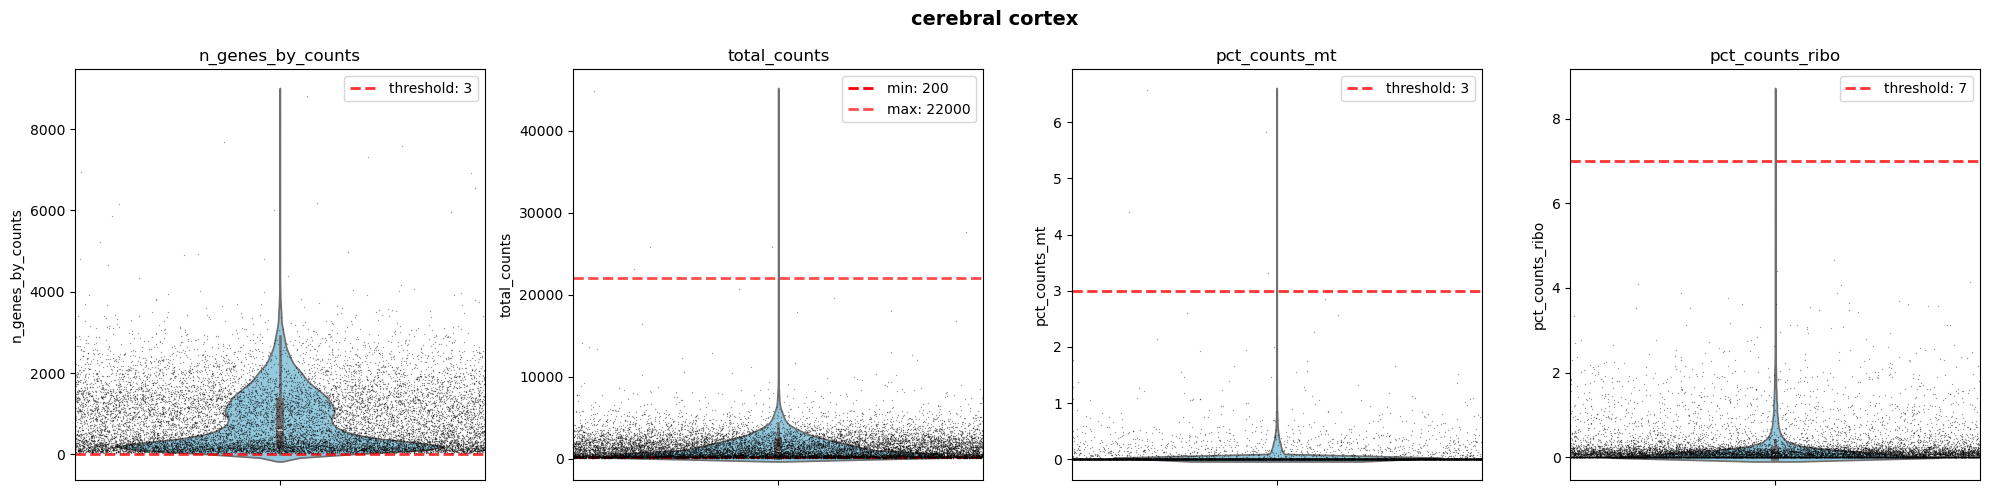

Plotting hippocampus


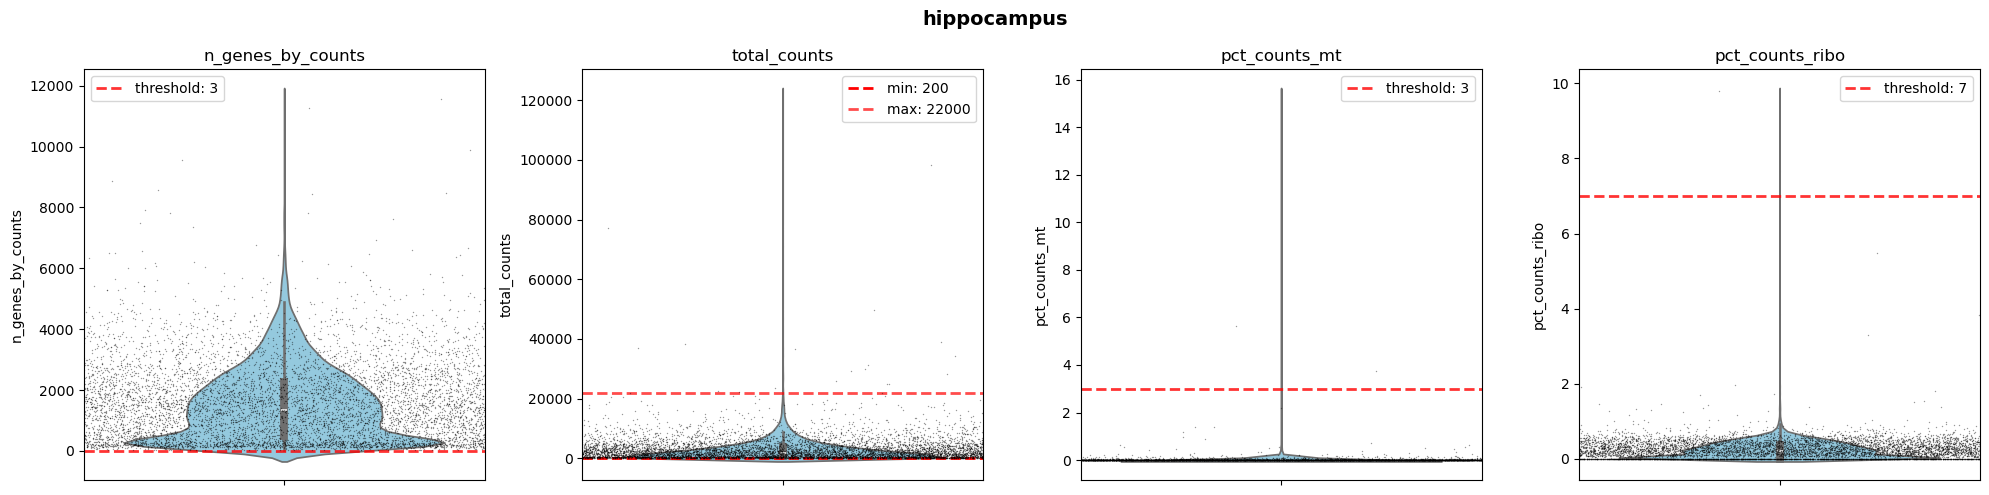

Plotting midbrain


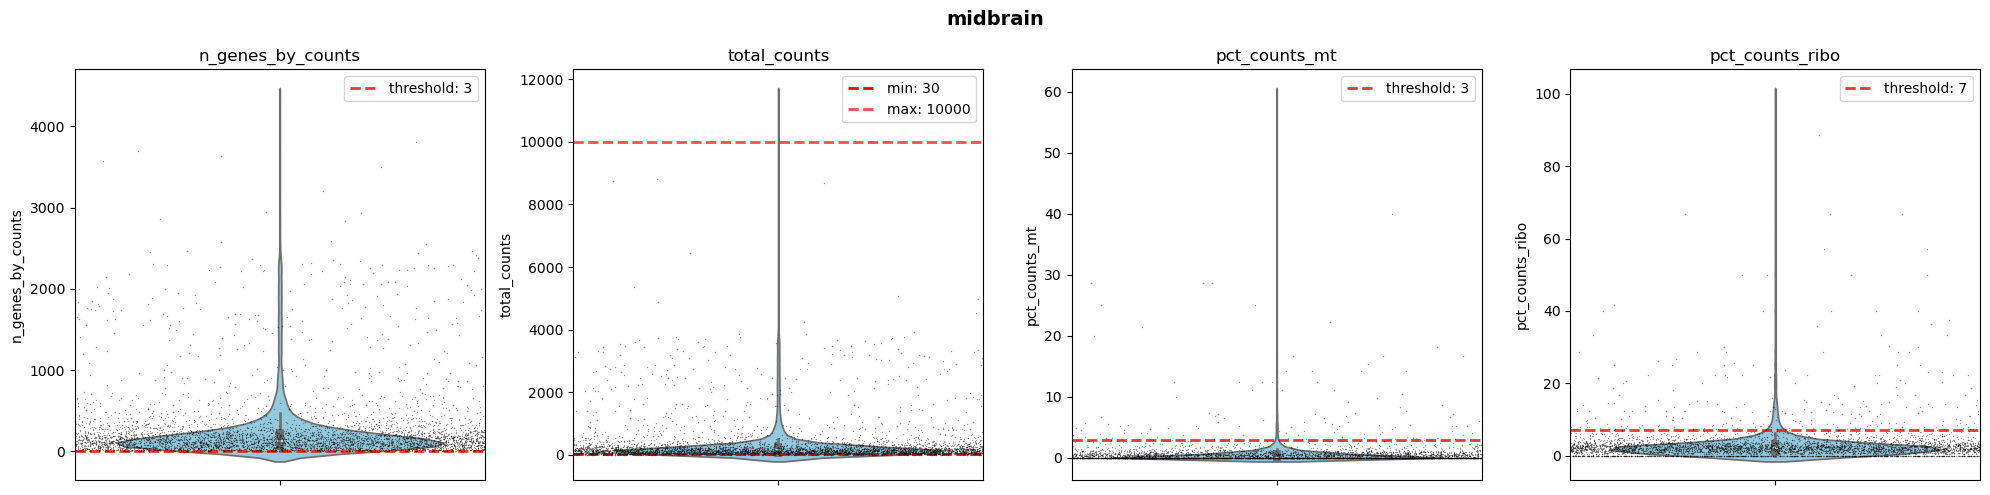

In [86]:
import matplotlib.pyplot as plt

qc_cuts = {"n_genes_by_counts":[3,3,3], 
        "min_total_counts":[200,200,30], 
        "max_total_counts":[22000,22000,10000],
        "pct_counts_mt": [3,3,3], 
        'pct_counts_ribo': [7,7,7]}

# Map tissue types to indices
tissue_to_idx = {"cerebral_cortex": 0, "hippocampus": 1, "midbrain": 2}

# Loop through all datasets
for adata in nmr_datas:
    tissue = adata.obs['tissue'].iloc[0]
    print(f"Plotting {tissue}")
    
    idx = tissue_to_idx.get(tissue, 0)
    
    # Create plot with seaborn for better control
    plot_keys = ["n_genes_by_counts", "total_counts", "pct_counts_mt", 'pct_counts_ribo']
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    for i, key in enumerate(plot_keys):
        # Create violin plot with seaborn
        data_to_plot = adata.obs[[key]].copy()
        sns.violinplot(data=data_to_plot, y=key, ax=axes[i], color='skyblue')
        
        # Add jitter points on top
        sns.stripplot(data=data_to_plot, y=key, ax=axes[i], color='black', alpha=0.4, size=1, jitter=1 )
        
        # Add threshold lines
        if key == "total_counts":
            axes[i].axhline(y=qc_cuts['min_total_counts'][idx], color='red', linestyle='--', linewidth=2, alpha=1, label=f'min: {qc_cuts["min_total_counts"][idx]}')
            axes[i].axhline(y=qc_cuts['max_total_counts'][idx], color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'max: {qc_cuts["max_total_counts"][idx]}')
            axes[i].legend()
        elif key in qc_cuts:
            threshold = qc_cuts[key][idx]
            axes[i].axhline(y=threshold, color='red', linestyle='--', linewidth=2, alpha=0.8, label=f'threshold: {threshold}')
            axes[i].legend()
        
        axes[i].set_title(f'{key}', fontsize=12)
    
    fig.suptitle(f'{tissue}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


In [87]:
# Filter out low-quality cells in nmr data
filtered_nmr_datas = []
for i, adata in enumerate(nmr_datas):
    print(f'Filtering {adata.obs["tissue"].iloc[0]} NMR data:')
    nmr_data = adata.copy()
    nmr_data = nmr_data[nmr_data.obs['total_counts'] > qc_cuts['min_total_counts'][i],:]
    nmr_data = nmr_data[nmr_data.obs['total_counts'] < qc_cuts['max_total_counts'][i],:]
    nmr_data = nmr_data[nmr_data.obs['pct_counts_mt'] < qc_cuts['pct_counts_mt'][i],:]
    nmr_data = nmr_data[nmr_data.obs['pct_counts_ribo'] < qc_cuts['pct_counts_ribo'][i],:]
    sc.pp.filter_genes(nmr_data, min_cells=qc_cuts['n_genes_by_counts'][i], inplace=True)
    filtered_nmr_datas.append(nmr_data)
    print(f'Filtered {adata.obs["tissue"].iloc[0]} NMR data: {adata.n_obs} cells, {adata.n_vars} genes → {nmr_data.n_obs} cells, {nmr_data.n_vars} genes.\n')

Filtering cerebral cortex NMR data:
Filtered cerebral cortex NMR data: 27879 cells, 20774 genes → 24378 cells, 17413 genes.

Filtering hippocampus NMR data:
Filtered hippocampus NMR data: 14311 cells, 20774 genes → 13634 cells, 17592 genes.

Filtering midbrain NMR data:
Filtered midbrain NMR data: 9136 cells, 20774 genes → 8070 cells, 13915 genes.



In [88]:
## Save NMR datas
for nmr_data in filtered_nmr_datas:
    tissue = nmr_data.obs['tissue'].iloc[0].replace(" ", "_")
    filename = f'/home/ratopin/big_data/nmr/{tissue}_nmr_adata_filtered{rev_n}.h5ad'
    nmr_data.write_h5ad(filename)
    print(f"AnnData from NMR {tissue} successfully saved to {filename}")

AnnData from NMR cerebral_cortex successfully saved to /home/ratopin/big_data/nmr/cerebral_cortex_nmr_adata_filtered14.h5ad
AnnData from NMR hippocampus successfully saved to /home/ratopin/big_data/nmr/hippocampus_nmr_adata_filtered14.h5ad
AnnData from NMR midbrain successfully saved to /home/ratopin/big_data/nmr/midbrain_nmr_adata_filtered14.h5ad


## Check human QC metrics

In [89]:
human_adult_datasets

[AnnData object with n_obs × n_vars = 17302 × 33538
     obs: 'Tissue', 'TotalUMIs', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'total_UMIs', 'sample_id', 'cluster_id', 'roi', 'dataset_source', 'species', 'region', 'Major Field', 'Supercluster', 'Specific', 'Top Enriched Genes'
     var: 'Chromosome', 'End', 'Gene', 'Start', 'Strand', 'human_gene_name', 'mt'
     uns: 'batch_condition', 'schema_version', 'title',
 AnnData object with n_obs × n_vars = 17557 × 33538
     obs: 'Tissue', 'TotalUMIs', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'total_UMIs', 'sample_id', 'cluster_id', 'roi', 'dataset_source', 'specie

In [90]:
human_dev_datasets

[AnnData object with n_obs × n_vars = 9028 × 59459
     obs: 'Age', 'CellClass', 'Chemistry', 'Region', 'Subregion', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'dissection', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'cluster_id', 'dataset_source', 'species', 'region', 'Major Field', 'Supercluster', 'Specific', 'Top Enriched Genes'
     var: 'Accession', 'Chromosome', 'End', 'GeneTotalUMIs', 'Start', 'Gene', 'human_gene_name', 'mt'
     uns: 'batch_condition', 'title'
     obsm: 'Factors', 'X_Embedding'
     varm: 'Loadings',
 AnnData object with n_obs × n_vars = 2810 × 59459
     obs: 'Age', 'CellClass', 'Chemistry', 'Region', 'Subregion', 'organism_ontology_term_id', 'disea

In [91]:
human_adult_datasets[0].var

,Chromosome,End,Gene,Start,Strand,human_gene_name,mt
Accession,,,,,,,
ENSG00000237613,1,36081,FAM138A,34554,-,FAM138A,False
ENSG00000238009,1,133723,AL627309.1,89295,-,AL627309.1,False
ENSG00000239945,1,91105,AL627309.3,89551,-,AL627309.3,False
ENSG00000239906,1,140339,AL627309.2,139790,-,AL627309.2,False
ENSG00000284733,1,451697,OR4F29,450703,-,OR4F29,False
...,...,...,...,...,...,...,...
ENSG00000235412,Y,24607025,TTTY4B,24570202,+,TTTY4B,False
ENSG00000183795,Y,24639207,BPY2B,24607560,+,BPY2B,False
ENSG00000205916,Y,24907040,DAZ4,24833843,+,DAZ4,False


In [92]:
for adata in human_dev_datasets:
    adata.var.index = adata.var['Accession']
    adata.var.drop(columns='Accession', inplace=True)


In [93]:
human_dev_datasets[0].var

,Chromosome,End,GeneTotalUMIs,Start,Gene,human_gene_name,mt
Accession,,,,,,,
ENSG00000223972,chr1,14409,3,11869,DDX11L1,DDX11L1,False
ENSG00000227232,chr1,29570,104073,14404,WASH7P,WASH7P,False
ENSG00000278267,chr1,17436,0,17369,MIR6859-1,MIR6859-1,False
ENSG00000284332,chr1,30503,0,30366,MIR1302-2,MIR1302-2,False
ENSG00000268020,chr1,53312,0,52473,OR4G4P,OR4G4P,False
...,...,...,...,...,...,...,...
ENSG00000275757,chr22_KI270733v1,174108,0,173956,5_8S_rRNA-8,5_8S_rRNA-8,False
ENSG00000278573,chr22_KI270734v1,60316,0,59711,AC007325.3,AC007325.3,False
ENSG00000276017,chr22_KI270734v1,74814,15,72411,AC007325.1,AC007325.1,False


In [94]:
for dataset_list in [human_adult_datasets, human_dev_datasets]:
    for adata in dataset_list:
        print(adata.obs['region'][0])
        # mitochondrial genes, "MT-" for human, "Mt-" for mouse
        if 'mt' not in nmr_data.var.columns:
            try: adata.var["mt"] = adata.var['Chromosome'] == 'MT'
            except: adata.var["mt"] = adata.var_names.str.startswith(("mt-", "MT-","Mt-")) |[gene in nmr_mito_genes for gene in adata.var_names]
        print(f'Found {adata.var["mt"].sum()} mito genes.')
        # ribosomal genes
        try: adata.var["ribo"] = [name in human_ribo_genes for name in adata.var['Gene']]
        except: adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL", "Rpl", "Rps"))
        print(f'Found {adata.var["ribo"].sum()} ribo genes.\n')
        sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True)

cerebral cortex
Found 13 mito genes.
Found 171 ribo genes.

hippocampus
Found 13 mito genes.
Found 171 ribo genes.

midbrain
Found 13 mito genes.
Found 171 ribo genes.

cerebral cortex
Found 37 mito genes.
Found 171 ribo genes.

hippocampus
Found 37 mito genes.
Found 171 ribo genes.

midbrain
Found 37 mito genes.
Found 171 ribo genes.



In [99]:
import sys
module_dir = os.path.abspath('../cannonical')
sys.path.append(module_dir)

In [100]:
from special_functions import plot_qc_violin_with_thres

Plotting cerebral cortex
Plotting hippocampus
Plotting midbrain


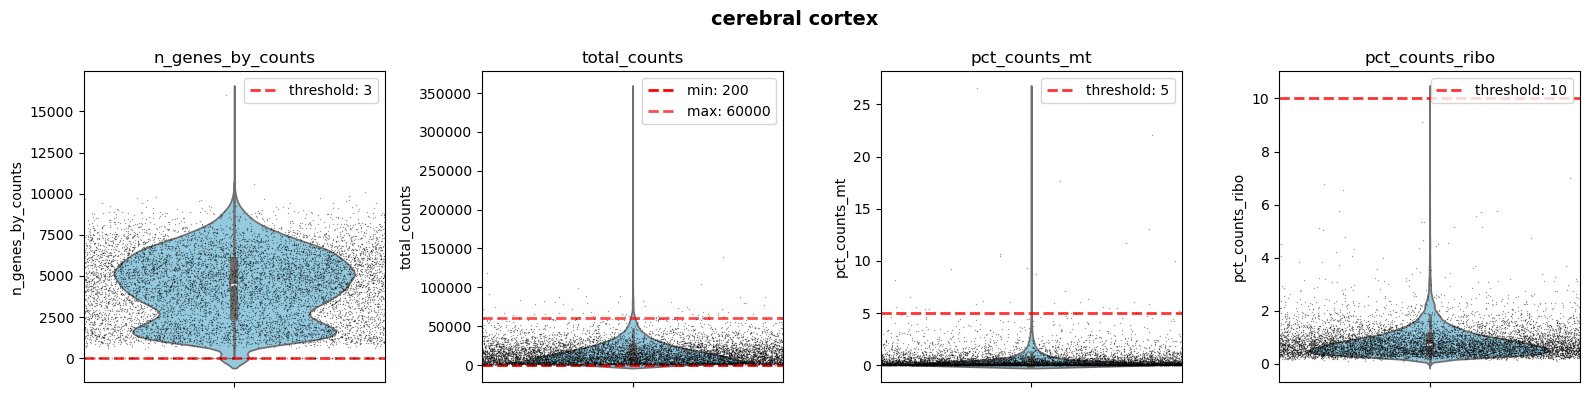

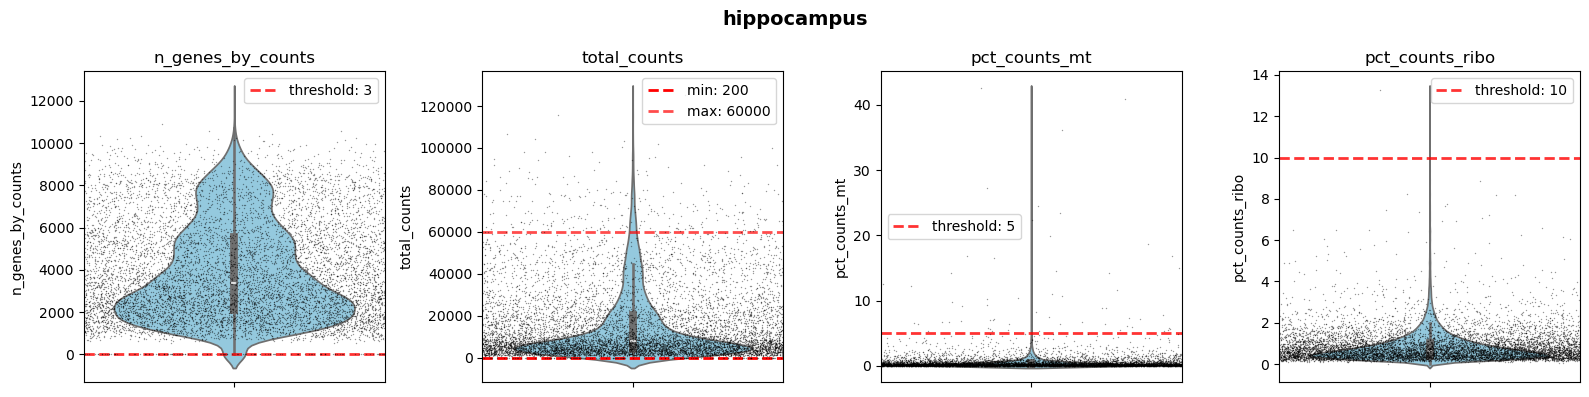

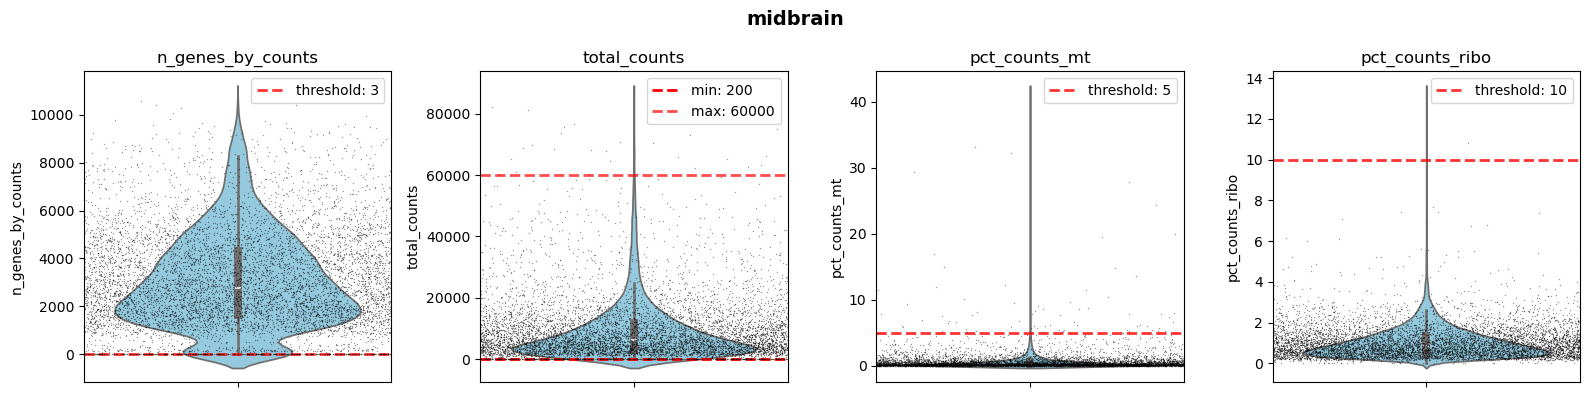

In [101]:
qc_cuts_adult = {
        "n_genes_by_counts":3, 
        "min_total_counts":200,
        "max_total_counts":60000,
        "pct_counts_mt": 5,
        'pct_counts_ribo': 10}
for adata in human_adult_datasets:
    plt, axes = plot_qc_violin_with_thres(adata, qc_cuts=qc_cuts_adult)
    plt.tight_layout()
    plt.show()

Plotting cerebral cortex
Plotting hippocampus
Plotting midbrain


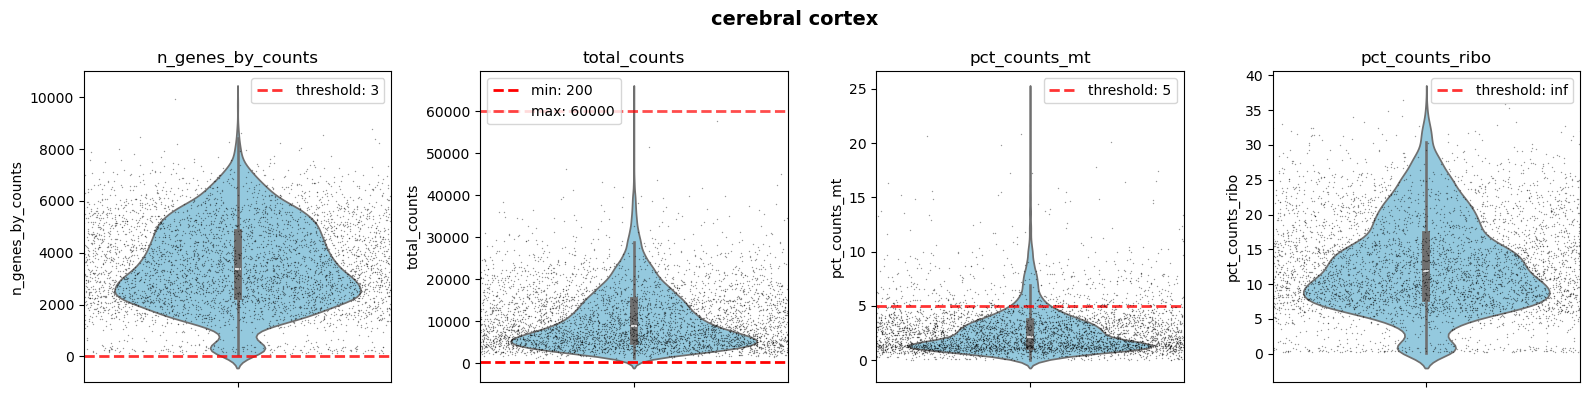

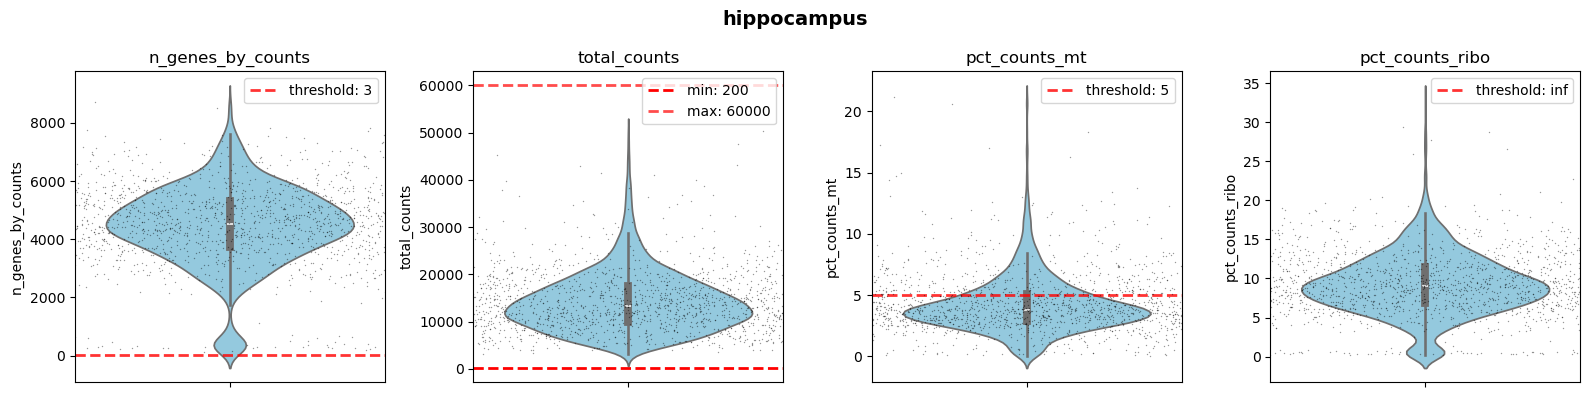

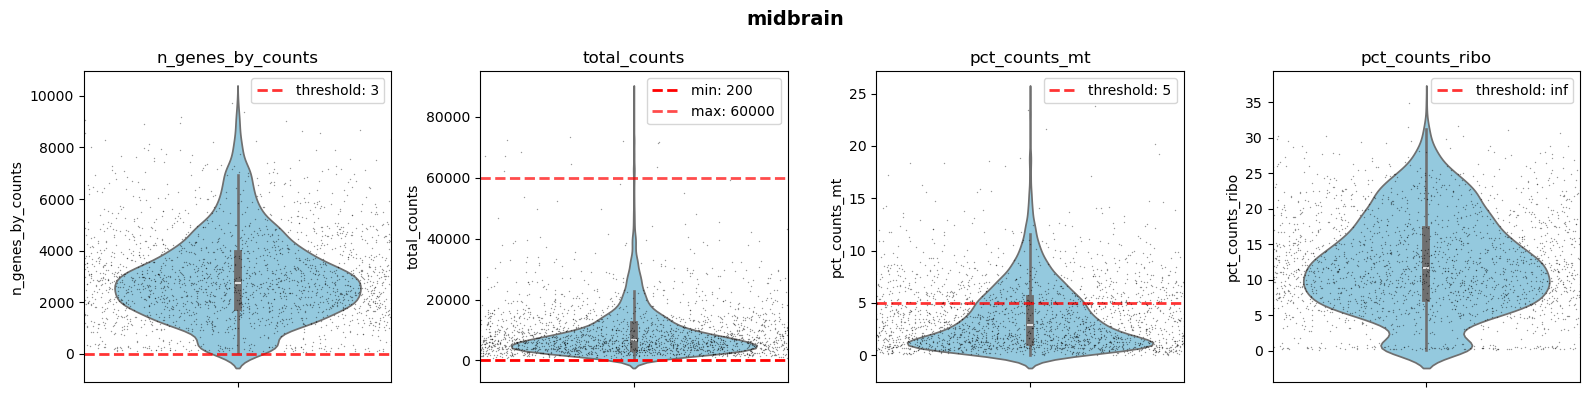

In [102]:
qc_cuts_dev={
        "n_genes_by_counts":3, 
        "min_total_counts":200,
        "max_total_counts":60000,
        "pct_counts_mt": 5,
        'pct_counts_ribo': np.inf}
for adata in human_dev_datasets:
    plt, axes = plot_qc_violin_with_thres(adata, qc_cuts=qc_cuts_dev)
    plt.tight_layout()
    plt.show()

In [103]:
# Filter out low-quality cells in human adult data
filtered_adult_datasets = []
for i, adata in enumerate(human_adult_datasets):
    print(f'Filtering {adata.obs["region"].iloc[0]} human adult data:')
    filtered_data = adata.copy()
    filtered_data = filtered_data[filtered_data.obs['total_counts'] > qc_cuts_adult['min_total_counts'],:]
    filtered_data = filtered_data[filtered_data.obs['total_counts'] < qc_cuts_adult['max_total_counts'],:]
    filtered_data = filtered_data[filtered_data.obs['pct_counts_mt'] < qc_cuts_adult['pct_counts_mt'],:]
    filtered_data = filtered_data[filtered_data.obs['pct_counts_ribo'] < qc_cuts_adult['pct_counts_ribo'],:]
    sc.pp.filter_genes(filtered_data, min_cells=qc_cuts_adult['n_genes_by_counts'], inplace=True)
    filtered_adult_datasets.append(filtered_data)
    print(f'Filtered {adata.obs["region"].iloc[0]} NMR data: {adata.n_obs} cells, {adata.n_vars} genes → {filtered_data.n_obs} cells, {filtered_data.n_vars} genes.\n')

Filtering cerebral cortex human adult data:
Filtered cerebral cortex NMR data: 17302 cells, 33538 genes → 16812 cells, 28541 genes.

Filtering hippocampus human adult data:
Filtered hippocampus NMR data: 17557 cells, 33538 genes → 16649 cells, 28619 genes.

Filtering midbrain human adult data:
Filtered midbrain NMR data: 15518 cells, 33538 genes → 14378 cells, 27985 genes.



In [104]:
# Filter out low-quality cells in human dev data
filtered_dev_datasets = []
for i, adata in enumerate(human_dev_datasets):
    print(f'Filtering {adata.obs["region"].iloc[0]} developing human data:')
    filtered_data = adata.copy()
    filtered_data = filtered_data[filtered_data.obs['total_counts'] > qc_cuts_dev['min_total_counts'],:]
    filtered_data = filtered_data[filtered_data.obs['total_counts'] < qc_cuts_dev['max_total_counts'],:]
    filtered_data = filtered_data[filtered_data.obs['pct_counts_mt'] < qc_cuts_dev['pct_counts_mt'],:]
    filtered_data = filtered_data[filtered_data.obs['pct_counts_ribo'] < qc_cuts_dev['pct_counts_ribo'],:]
    sc.pp.filter_genes(filtered_data, min_cells=qc_cuts_dev['n_genes_by_counts'], inplace=True)
    filtered_dev_datasets.append(filtered_data)
    print(f'Filtered {adata.obs["region"].iloc[0]} NMR data: {adata.n_obs} cells, {adata.n_vars} genes → {filtered_data.n_obs} cells, {filtered_data.n_vars} genes.\n')

Filtering cerebral cortex developing human data:
Filtered cerebral cortex NMR data: 9028 cells, 59459 genes → 8046 cells, 30835 genes.

Filtering hippocampus developing human data:
Filtered hippocampus NMR data: 2810 cells, 59459 genes → 2061 cells, 27141 genes.

Filtering midbrain developing human data:
Filtered midbrain NMR data: 4281 cells, 59459 genes → 3045 cells, 27135 genes.



Plotting cerebral cortex
Plotting hippocampus
Plotting midbrain


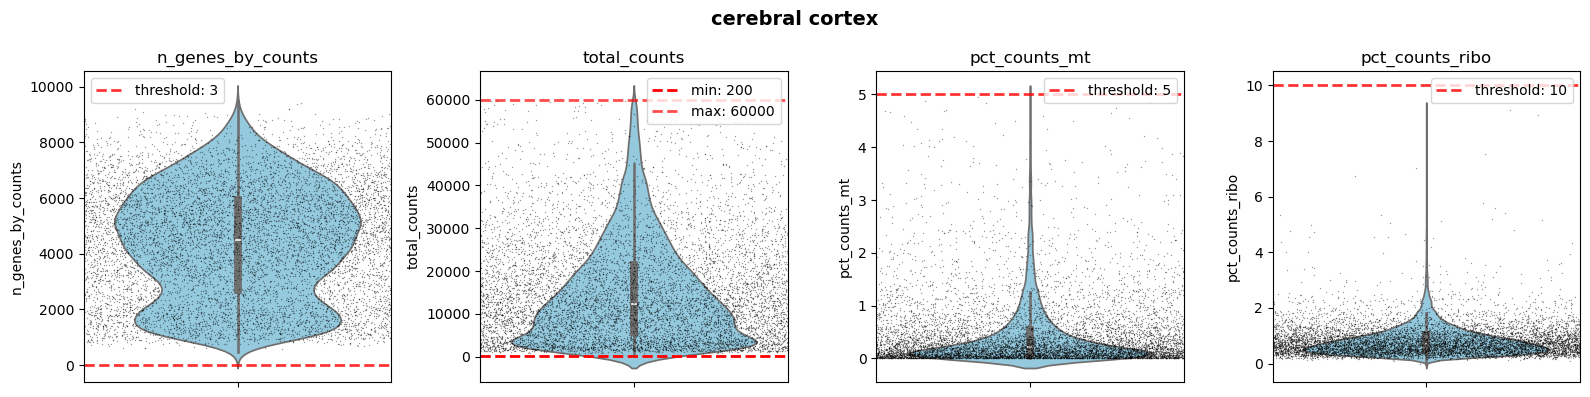

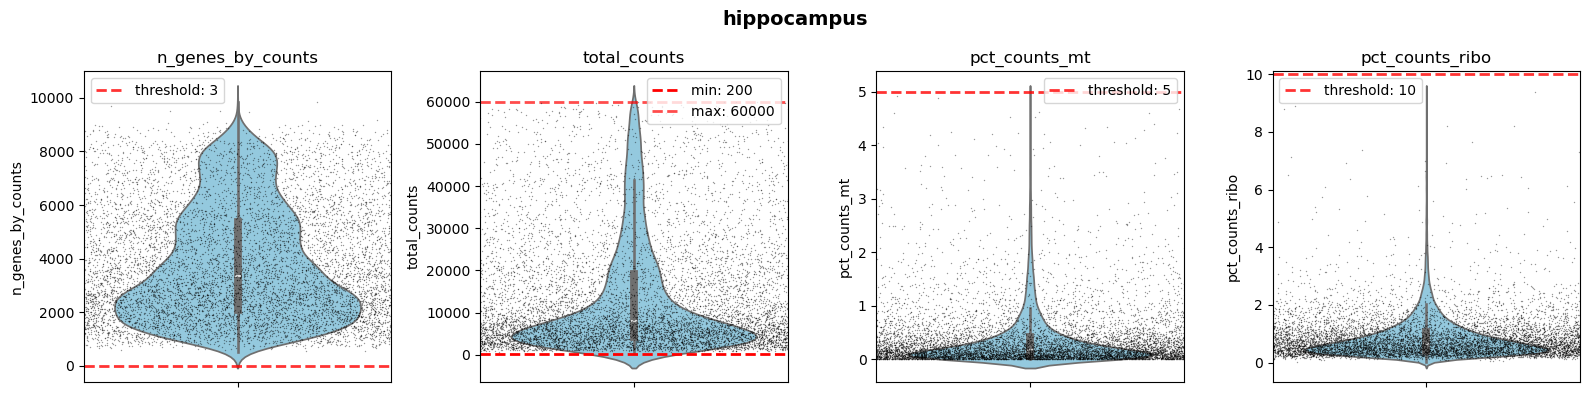

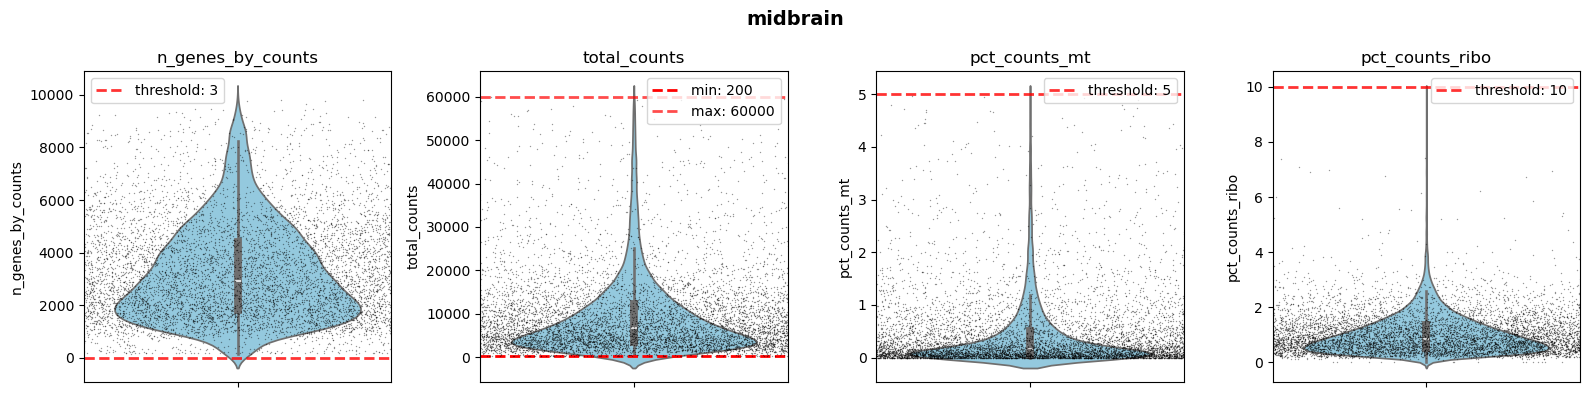

In [105]:
for adata in filtered_adult_datasets:
    plt, axes = plot_qc_violin_with_thres(adata, qc_cuts=qc_cuts_adult)
    plt.tight_layout()
    plt.show()

Plotting cerebral cortex
Plotting hippocampus
Plotting midbrain


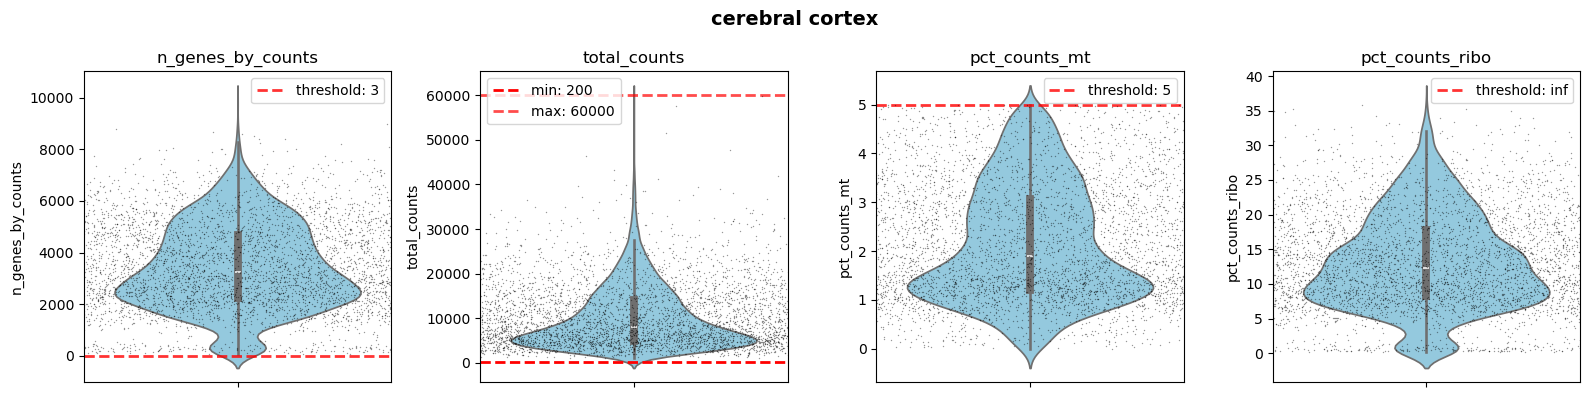

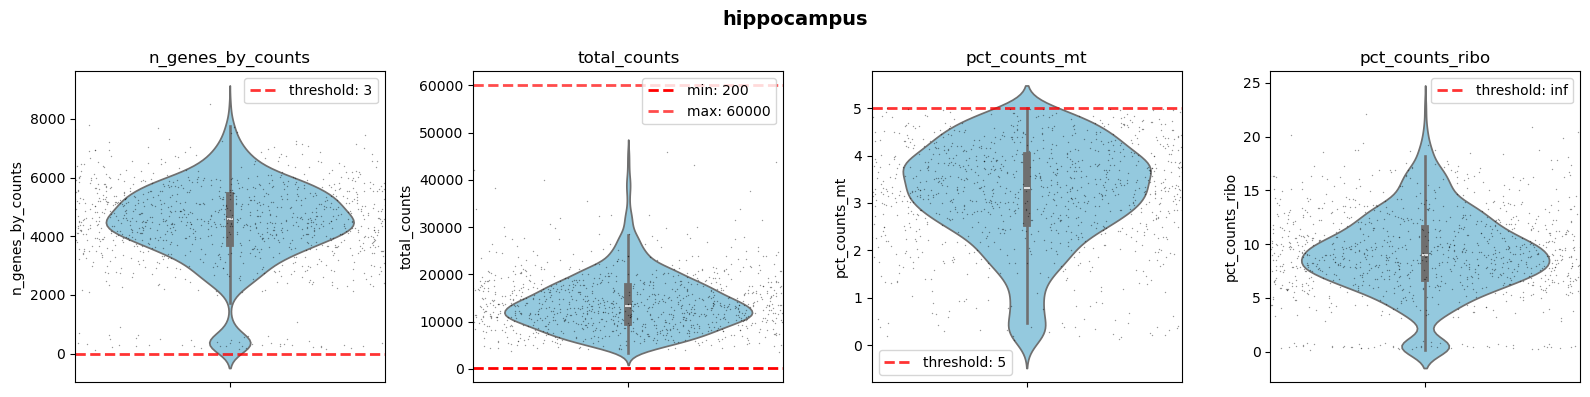

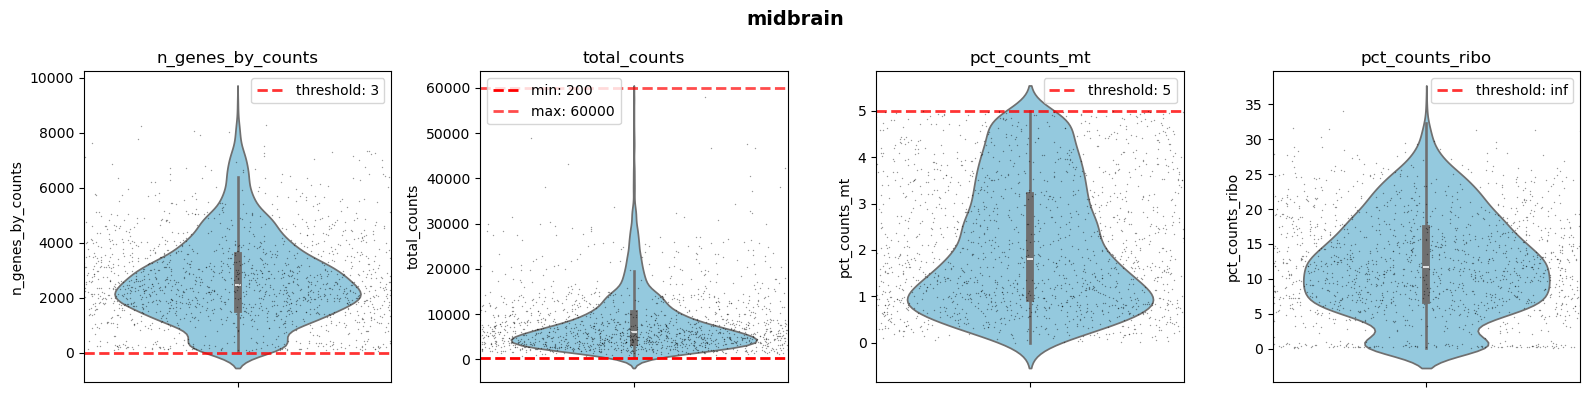

In [106]:
for adata in filtered_dev_datasets:
    plt, axes = plot_qc_violin_with_thres(adata, qc_cuts=qc_cuts_dev)
    plt.tight_layout()
    plt.show()

In [107]:
for adata in filtered_adult_datasets:
    adata.obs['stage'] = 'adult'
for adata in filtered_dev_datasets:
    adata.obs['stage'] = 'developing'


In [108]:
## Save human filtered dataset subsets
for adata in filtered_adult_datasets:
    tissue = adata.obs['region'].iloc[0].replace(" ", "_")
    stage =  adata.obs['stage'].iloc[0]
    filename = f'/home/ratopin/big_data/human/{tissue}_human_{stage}_adata_filtered{rev_n}.h5ad'
    adata.write_h5ad(filename)
    print(f"AnnData from human {stage} - {tissue} successfully saved to {filename}")

AnnData from human adult - cerebral_cortex successfully saved to /home/ratopin/big_data/human/cerebral_cortex_human_adult_adata_filtered14.h5ad
AnnData from human adult - hippocampus successfully saved to /home/ratopin/big_data/human/hippocampus_human_adult_adata_filtered14.h5ad
AnnData from human adult - midbrain successfully saved to /home/ratopin/big_data/human/midbrain_human_adult_adata_filtered14.h5ad


In [109]:
## Save human filtered dataset subsets
for adata in filtered_dev_datasets:
    tissue = adata.obs['region'].iloc[0].replace(" ", "_")
    stage =  adata.obs['stage'].iloc[0]
    filename = f'/home/ratopin/big_data/human/{tissue}_human_{stage}_adata_filtered{rev_n}.h5ad'
    adata.write_h5ad(filename)
    print(f"AnnData from human {stage} - {tissue} successfully saved to {filename}")

AnnData from human developing - cerebral_cortex successfully saved to /home/ratopin/big_data/human/cerebral_cortex_human_developing_adata_filtered14.h5ad
AnnData from human developing - hippocampus successfully saved to /home/ratopin/big_data/human/hippocampus_human_developing_adata_filtered14.h5ad
AnnData from human developing - midbrain successfully saved to /home/ratopin/big_data/human/midbrain_human_developing_adata_filtered14.h5ad


## Tidy up adatas prior to merging
Subset each human dataset.var by only shared genes by at least 2 species (nmr & human)

### Tidy up Human 

For each region of human (adult and dev) adata:

1. Map genes to gene_reference['human_gene_name']

2. **Drop NaNs** (non-orthologus genes between human and nmr)

3. Drop duplicates (In case the gene names repeat for a pair of accesion numbers)

4. Set ['human_gene_name'] column to var_names


In [110]:
gene_reference[["human_gene_acc", "human_gene_name"]]

,human_gene_acc,human_gene_name
0,ENSG00000175899,A2M
1,ENSG00000184389,A3GALT2
2,ENSG00000128274,A4GALT
3,ENSG00000118017,A4GNT
4,ENSG00000094914,AAAS
...,...,...
14976,ENSG00000164761,TNFRSF11B
14977,ENSG00000126602,TRAP1
14978,ENSG00000146469,VIP
14979,ENSG00000156853,ZNF689


In [111]:
from scipy import sparse

def drop_lower_count_duplicates(adata, gene_key="global_name", verbose=True):
    """
    Remove duplicated genes by keeping the one with highest global expression.
    Prints info about duplicates if verbose=True.
    
    Parameters
    ----------
    adata : AnnData
    gene_key : str
        Column in `adata.var` to identify gene names (default "global_name").
    verbose : bool
        If True, print duplicate genes and their counts.
    
    Returns
    -------
    AnnData with unique genes
    """
    # Get gene names
    if gene_key in adata.var.columns:
        genes = adata.var[gene_key].astype(str)
    else:
        genes = adata.var_names.astype(str)

    # Compute total counts per gene (sparse-aware)
    if sparse.issparse(adata.X):
        total_counts = np.array(adata.X.sum(axis=0)).flatten()
    else:
        total_counts = adata.X.sum(axis=0)

    # Build dataframe
    df = pd.DataFrame({
        "gene": genes.values,
        "total_counts": total_counts,
        "idx": np.arange(len(genes))
    })

    # Find duplicates
    dupes = df[df.duplicated("gene", keep=False)].sort_values("gene")

    if verbose and not dupes.empty:
        print("\nDuplicate genes found:")
        for g, sub in dupes.groupby("gene"):
            print(f"  {g}:")
            for _, row in sub.iterrows():
                print(f"    idx={row['idx']} total_counts={row['total_counts']}")
    
    # Keep max count per gene
    keep_idx = df.loc[df.groupby("gene")["total_counts"].idxmax(), "idx"].values

    # Subset AnnData
    adata_unique = adata[:, keep_idx].copy()
    adata_unique.var_names = genes.iloc[keep_idx].values

    return adata_unique


In [112]:
for lst in (filtered_adult_datasets, filtered_dev_datasets):
    for i in range(len(lst)):
        adata = lst[i]
        print(f"{adata.obs['stage'].iloc[0]} - {adata.obs['region'].iloc[0]}: {adata.n_obs} cells, {adata.n_vars} genes")
        print(adata.var_names[:5])
        # Map gene accession to global names
        adata.var['global_name'] = adata.var_names.map(gene_reference.set_index('human_gene_acc')['human_gene_name'])
        # Keep only genes with a mapped global_name by subsetting the AnnData (must match adata.n_vars)
        mask = adata.var['global_name'].notna()
        print(f"Mapped global names: {mask.sum()} / {adata.n_vars}")
        adata = adata[:, mask].copy()
        print(f"After dropping NaN global names: {adata.n_obs} cells, {adata.n_vars} genes")
        # Drop duplicates (keeps the higher-count gene)
        adata = drop_lower_count_duplicates(adata)
        print(f'After droping duplicates: {adata.n_obs} cells, {adata.n_vars} genes')
        # Set global_name as var_names and make unique
        adata.var_names = adata.var['global_name']
        adata.var_names_make_unique()
        # Put the modified AnnData back into the tidy list
        lst[i] = adata

adult - cerebral cortex: 16812 cells, 28541 genes
Index(['ENSG00000238009', 'ENSG00000239945', 'ENSG00000225880',
       'ENSG00000230368', 'ENSG00000223764'],
      dtype='object', name='Accession')
Mapped global names: 13779 / 28541
After dropping NaN global names: 16812 cells, 13779 genes
After droping duplicates: 16812 cells, 13779 genes
adult - hippocampus: 16649 cells, 28619 genes
Index(['ENSG00000238009', 'ENSG00000239945', 'ENSG00000225880',
       'ENSG00000230368', 'ENSG00000223764'],
      dtype='object', name='Accession')
Mapped global names: 13760 / 28619
After dropping NaN global names: 16649 cells, 13760 genes
After droping duplicates: 16649 cells, 13760 genes
adult - midbrain: 14378 cells, 27985 genes
Index(['ENSG00000238009', 'ENSG00000239945', 'ENSG00000225880',
       'ENSG00000230368', 'ENSG00000223764'],
      dtype='object', name='Accession')
Mapped global names: 13702 / 27985
After dropping NaN global names: 14378 cells, 13702 genes
After droping duplicates: 1437

In [113]:
filtered_adult_datasets[0].var_names

Index(['A1CF', 'A2M', 'A3GALT2', 'A4GALT', 'A4GNT', 'AAAS', 'AACS', 'AADACL2',
       'AADAT', 'AAGAB',
       ...
       'ZSWIM8', 'ZSWIM9', 'ZUP1', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDC', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', name='global_name', length=13779)

#### Tidy up NMR


For each region of nmr adata:

1. Map genes to gene_reference['human_gene_name']

2. **Fill NaNs** with original nmr genes (preserve nmr genes for future analysis)

3. Drop duplicates (In case any gene name repeats during orthologus merging)

4. Set ['human_gene_name'] column to var_names

In [114]:
for i in range(len(filtered_nmr_datas)):
    adata = filtered_nmr_datas[i]
    print(f"{adata.obs['tissue'].iloc[0]}: {adata.n_obs} cells, {adata.n_vars} genes")
    print(adata.var_names[:5])
    adata.var['global_name'] = adata.var_names.map(dict(zip(gene_reference['nmr_gene_name'], gene_reference['human_gene_name'])))
    adata.var['original_names'] = adata.var_names.to_list()
    adata.var['global_name'].fillna(adata.var['original_names'], inplace=True)
    # Drop duplicates (keeps the higher-count gene)
    adata = drop_lower_count_duplicates(adata)
    print(f'After droping duplicates: {adata.n_obs} cells, {adata.n_vars} genes')
    # Set global_name as var_names and make unique
    adata.var_names = adata.var['global_name']
    adata.var_names_make_unique()
    # Put the modified AnnData back into the tidy list
    filtered_nmr_datas[i] = adata

cerebral cortex: 24378 cells, 17413 genes
Index(['ZMYND10', 'AMIGO3', 'TNFSF10', 'NPRL2', 'GMPPB'], dtype='object')

Duplicate genes found:
  ACP1:
    idx=10175 total_counts=168.0
    idx=14752 total_counts=158.0
  AKAP7:
    idx=5409 total_counts=70.0
    idx=5430 total_counts=1480.0
  AMD1:
    idx=14615 total_counts=32.0
    idx=16699 total_counts=2714.0
  AMN:
    idx=1703 total_counts=215.0
    idx=17171 total_counts=307.0
  APPL2:
    idx=12220 total_counts=4250.0
    idx=4543 total_counts=672.0
  AR:
    idx=9406 total_counts=631.0
    idx=15730 total_counts=225.0
  ARG1:
    idx=5437 total_counts=740.0
    idx=7371 total_counts=58.0
  ARID3C:
    idx=1841 total_counts=127.0
    idx=1869 total_counts=488.0
  ASIP:
    idx=14508 total_counts=46.0
    idx=12141 total_counts=6949.0
  BNC1:
    idx=15519 total_counts=71908.0
    idx=8109 total_counts=3.0
  BRCC3:
    idx=17267 total_counts=1872.0
    idx=12214 total_counts=822.0
  BRF1:
    idx=1734 total_counts=331.0
    idx=1757 

In [115]:
filtered_adult_datasets[0]

AnnData object with n_obs × n_vars = 16812 × 13779
    obs: 'Tissue', 'TotalUMIs', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'total_UMIs', 'sample_id', 'cluster_id', 'roi', 'dataset_source', 'species', 'region', 'Major Field', 'Supercluster', 'Specific', 'Top Enriched Genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'stage'
    var: 'Chromosome', 'End', 'Gene', 'Start', 'Strand', 'human_gene_name', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [116]:
filtered_nmr_datas[0]

AnnData object with n_obs × n_vars = 24378 × 17303
    obs: 'species', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_tf', 'log1p_total_counts_tf', 'pct_counts_tf', 'n_counts', 'qc_composite', 'qc_label', 'sample_id', 'replicate'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'global_name', 'original_names'

## Merge datasets from human and nmr per region

### only choose important columns to keep from obs

In [117]:
filtered_nmr_datas[0].obs[['species', 'sample', 'tissue', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb',
       'total_counts_tf', 'log1p_total_counts_tf', 'pct_counts_tf', 'n_counts',
       'qc_composite', 'qc_label', 'sample_id', 'replicate']]

,species,sample,tissue,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,...,log1p_total_counts_hb,pct_counts_hb,total_counts_tf,log1p_total_counts_tf,pct_counts_tf,n_counts,qc_composite,qc_label,sample_id,replicate
AAACCCAAGAAGCGAA-1-NMR1,nmr,NMR1,cerebral cortex,1559,7.352441,2298.0,7.740230,14.882507,22.062663,32.245431,...,0.0,0.0,23.0,3.178054,1.000870,2298.0,8.0,acceptable,1,1
AAACCCAAGGAGGCAG-1-NMR1,nmr,NMR1,cerebral cortex,1312,7.180070,1777.0,7.483244,14.350028,21.890827,33.145751,...,0.0,0.0,24.0,3.218876,1.350591,1777.0,60.0,acceptable,1,1
AAACCCACAAATCAAG-1-NMR1,nmr,NMR1,cerebral cortex,491,6.198479,679.0,6.522093,29.602356,42.415317,57.142857,...,0.0,0.0,2.0,1.098612,0.294551,679.0,92.0,acceptable,1,1
AAACCCACAGTCTACA-1-NMR1,nmr,NMR1,cerebral cortex,1841,7.518607,3369.0,8.122668,19.709112,27.634313,38.171564,...,0.0,0.0,36.0,3.610918,1.068566,3369.0,1.0,acceptable,1,1
AAACCCAGTACGTAGG-1-NMR1,nmr,NMR1,cerebral cortex,478,6.171701,710.0,6.566672,32.535211,46.760563,60.845070,...,0.0,0.0,8.0,2.197225,1.126761,710.0,92.0,acceptable,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCACTGAATC-1-NMR2,nmr,NMR2,cerebral cortex,189,5.247024,282.0,5.645447,48.936170,68.439716,100.000000,...,0.0,0.0,8.0,2.197225,2.836879,282.0,25.5,acceptable,2,2
TTTGTTGGTCCCTCAT-1-NMR2,nmr,NMR2,cerebral cortex,1719,7.450080,3030.0,8.016648,19.042904,27.689769,38.184818,...,0.0,0.0,33.0,3.526361,1.089109,3030.0,59.0,acceptable,2,2
TTTGTTGGTTCGGCTG-1-NMR2,nmr,NMR2,cerebral cortex,243,5.497168,447.0,6.104793,52.796421,68.008949,90.380313,...,0.0,0.0,3.0,1.386294,0.671141,447.0,59.0,acceptable,2,2
TTTGTTGGTTCTCGCT-1-NMR2,nmr,NMR2,cerebral cortex,773,6.651572,1431.0,7.266827,28.721174,40.880503,56.254368,...,0.0,0.0,29.0,3.401197,2.026555,1431.0,27.5,acceptable,2,2


In [118]:
# Merge (outer) datasets from the same region
outer_datasets = []
for human_adult_adata, human_dev_adata, nmr_adata in zip(filtered_adult_datasets,filtered_dev_datasets, filtered_nmr_datas):
    human_dev_adata.obs = human_dev_adata.obs[['Age', 'CellClass', 'Region', 'Subregion',
       'donor_id', 'suspension_type', 'dissection', 'cell_cycle_score',
       'total_genes', 'total_UMIs', 'sample_id', 'cluster_id',
       'dataset_source', 'stage', 'species', 'region', 'Major Field', 'Supercluster',
       'Specific', 'Top Enriched Genes', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo']]
    human_adult_adata.obs = human_adult_adata.obs[['donor_id', 'suspension_type',
       'dissection', 'total_UMIs', 'sample_id', 'cluster_id', 'roi',
       'dataset_source', 'stage', 'species', 'region', 'Major Field', 'Supercluster',
       'Specific', 'Top Enriched Genes', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       ]]
    nmr_adata.obs['donor_id'] = ['ratopin'+ str(i) for i in nmr_adata.obs['replicate']]
    nmr_adata.obs = nmr_adata.obs[['species', 'sample', 'tissue', 'donor_id',  'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb',
       'total_counts_tf', 'log1p_total_counts_tf', 'pct_counts_tf', 'n_counts',
       'qc_composite', 'qc_label']]
    nmr_adata.obs.rename(columns={'sample':'sample_id','tissue':'region'}, inplace=True)
    
    combined_adata = nmr_adata.concatenate([human_adult_adata,human_dev_adata], join='outer', batch_key='dataset', batch_categories=["nmr", 'human_adult','human_dev'],  index_unique=None, fill_value=0)
    outer_datasets.append(combined_adata)
    print("Merged AnnData (outer):", combined_adata.shape)


Merged AnnData (outer): (49236, 19286)
Merged AnnData (outer): (32344, 19320)
Merged AnnData (outer): (25493, 17146)


In [119]:
outer_datasets

[AnnData object with n_obs × n_vars = 49236 × 19286
     obs: 'species', 'sample_id', 'region', 'donor_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_tf', 'log1p_total_counts_tf', 'pct_counts_tf', 'n_counts', 'qc_composite', 'qc_label', 'suspension_type', 'dissection', 'total_UMIs', 'cluster_id', 'roi', 'dataset_source', 'stage', 'Major Field', 'Supercluster', 'Specific', 'Top Enriched Genes', 'Age', 'CellClass', 'Region', 'Subregion', 'cell_cycle_score', 'total_genes', 'dataset'
     var: 'mt-human_adult', 'ribo-human_adult', 'n_cells_by_counts-human_adult', 'mean_counts-human_adult', 'log1p_mean_counts-human_adult', 'pct

In [120]:
for dataset in outer_datasets:
    print(dataset.obs['dataset'].value_counts())

dataset
nmr            24378
human_adult    16812
human_dev       8046
Name: count, dtype: int64
dataset
human_adult    16649
nmr            13634
human_dev       2061
Name: count, dtype: int64
dataset
human_adult    14378
nmr             8070
human_dev       3045
Name: count, dtype: int64


In [121]:
outer_datasets[0].obs.columns

Index(['species', 'sample_id', 'region', 'donor_id', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb',
       'total_counts_tf', 'log1p_total_counts_tf', 'pct_counts_tf', 'n_counts',
       'qc_composite', 'qc_label', 'suspension_type', 'dissection',
       'total_UMIs', 'cluster_id', 'roi', 'dataset_source', 'stage',
       'Major Field', 'Supercluster', 'Specific', 'Top Enriched Genes', 'Age',
       'CellClass', 'Region', 'Subregion', 'cell_cycle_score', 'total_genes',
       'dataset'],
      dtype='object')

In [122]:
outer_datasets[0].obs

,species,sample_id,region,donor_id,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,...,Supercluster,Specific,Top Enriched Genes,Age,CellClass,Region,Subregion,cell_cycle_score,total_genes,dataset
AAACCCAAGAAGCGAA-1-NMR1,nmr,NMR1,cerebral cortex,ratopin1,1559,7.352441,2298.0,7.740230,14.882507,22.062663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nmr
AAACCCAAGGAGGCAG-1-NMR1,nmr,NMR1,cerebral cortex,ratopin1,1312,7.180070,1777.0,7.483244,14.350028,21.890827,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nmr
AAACCCACAAATCAAG-1-NMR1,nmr,NMR1,cerebral cortex,ratopin1,491,6.198479,679.0,6.522093,29.602356,42.415317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nmr
AAACCCACAGTCTACA-1-NMR1,nmr,NMR1,cerebral cortex,ratopin1,1841,7.518607,3369.0,8.122668,19.709112,27.634313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nmr
AAACCCAGTACGTAGG-1-NMR1,nmr,NMR1,cerebral cortex,ratopin1,478,6.171701,710.0,6.566672,32.535211,46.760563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nmr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10X257_6:CCCTAACTCGGTCTAA,human,10X257_6,cerebral cortex,XDD:385,5037,8.524764,20232.0,9.915071,17.274614,24.312970,...,Vascular,VendC,"CLEC3B,FLT1,SOX18,CLDN5,ITM2A,SLC38A5,PECAM1,E...",14.0,Vascular,Telencephalon,Cortex,0.002076,5037,human_dev
10X257_6:CTGCCTAGTGTCTTCC,human,10X257_6,cerebral cortex,XDD:385,2605,7.865572,5745.0,8.656260,22.088773,28.424717,...,Vascular,VendC,"CLEC3B,FLT1,SOX18,CLDN5,ITM2A,SLC38A5,PECAM1,E...",14.0,Vascular,Telencephalon,Cortex,0.001567,2605,human_dev
10X257_6:GAGTTTGTCCTGTAGA,human,10X257_6,cerebral cortex,XDD:385,4886,8.494334,15823.0,9.669283,14.756999,20.862036,...,Vascular,VendC,"CLEC3B,FLT1,SOX18,CLDN5,ITM2A,SLC38A5,PECAM1,E...",14.0,Vascular,Telencephalon,Cortex,0.001011,4886,human_dev
10X257_6:GATCATGAGACCATGG,human,10X257_6,cerebral cortex,XDD:385,7034,8.858653,31324.0,10.352172,13.762610,20.188992,...,Vascular,VendC,"CLEC3B,FLT1,SOX18,CLDN5,ITM2A,SLC38A5,PECAM1,E...",14.0,Vascular,Telencephalon,Cortex,0.001564,7034,human_dev


## Save Merged objects

In [123]:
for dataset in outer_datasets:
    dataset.var['mt-human_adult'].fillna(False, inplace=True)
    dataset.var['ribo-human_adult'].fillna(False, inplace=True)
    dataset.var['mt-human_dev'].fillna(False, inplace=True)
    dataset.var['ribo-human_dev'].fillna(False, inplace=True)
    dataset.var['mt-nmr'].fillna(False, inplace=True)
    dataset.var['ribo-nmr'].fillna(False, inplace=True) 

In [124]:
filtered_adult_datasets[0].obs[['cluster_id', 'stage', 'species', 'region', 'Major Field', 'Supercluster',
       'Specific']]

,cluster_id,stage,species,region,Major Field,Supercluster,Specific
CellID,,,,,,,
10X264_1:CCTCTCCGTATGAAAC,1,adult,human,cerebral cortex,Non-neuron,Miscellaneous,Tcell
10X269_5:CAACCAAGTAATACCC,1,adult,human,cerebral cortex,Non-neuron,Miscellaneous,Tcell
10X240_4:AGGATCTGTAGTTCCA,1,adult,human,cerebral cortex,Non-neuron,Miscellaneous,Tcell
10X216_8:GTCGAATCATGGAGAC,1,adult,human,cerebral cortex,Non-neuron,Miscellaneous,Tcell
10X241_4:GACTGATAGGCTTTCA,2,adult,human,cerebral cortex,Non-neuron,Miscellaneous,Nkcell
...,...,...,...,...,...,...,...
10X159_3:CAGGGCTCACGCTGAC,460,adult,human,cerebral cortex,Excitatory neuron,Thalamic excitatory,Thex
10X160_8:CATTGCCCATAGAATG,460,adult,human,cerebral cortex,Excitatory neuron,Thalamic excitatory,Thex
10X159_1:AGTGCCGCAGGGAGAG,460,adult,human,cerebral cortex,Excitatory neuron,Thalamic excitatory,Thex


In [125]:
outer_datasets[0].obs['cluster_id'].value_counts()

cluster_id
138.0    431
52.0     406
123.0    404
129.0    361
174.0    354
        ... 
60.0       1
77.0       1
63.0       1
84.0       1
82.0       1
Name: count, Length: 362, dtype: int64

In [126]:
# Save objecs
for dataset in outer_datasets:
    region = dataset.obs['region'].iloc[0].replace(" ", "_")
    filename = f'/home/ratopin/big_data/combined/{region}_combined_outer_adata{rev_n}.h5ad'
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    dataset.write_h5ad(str(filename))
    print(f"Combined AnnData from {region} successfully saved to {filename}")

Combined AnnData from cerebral_cortex successfully saved to /home/ratopin/big_data/combined/cerebral_cortex_combined_outer_adata14.h5ad
Combined AnnData from hippocampus successfully saved to /home/ratopin/big_data/combined/hippocampus_combined_outer_adata14.h5ad
Combined AnnData from midbrain successfully saved to /home/ratopin/big_data/combined/midbrain_combined_outer_adata14.h5ad


In [127]:
filename

'/home/ratopin/big_data/combined/midbrain_combined_outer_adata14.h5ad'